In [2]:
import pandas as pd
import numpy as np
import evofr as ef
import matplotlib.pyplot as plt
import string
import yaml

In [3]:
import sys
import os

# Add "../scripts" to sys.path
scripts_dir = os.path.abspath(os.path.join(os.path.dirname("."), "../utils"))
sys.path.append(scripts_dir)

In [4]:
import plot_utils

In [5]:
ANALYSIS = "xbb15"

with open("../config/config.yaml") as stream:
    config = yaml.safe_load(stream)
    
analysis_config = config["analysis_period"][ANALYSIS]

In [6]:
raw_seq = pd.read_csv(f"../data/{ANALYSIS}/collapsed_seq_counts.tsv", sep="\t")
raw_seq = raw_seq[raw_seq.location == "USA"]
raw_variant_parents = pd.read_csv(f"../data/{ANALYSIS}/pango_variant_relationships.tsv", sep="\t")
raw_variant_parents = raw_variant_parents.rename(columns={"closest_parent":"parent"})
data = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot=analysis_config["pivot"])

In [7]:
missing_parents = raw_variant_parents[raw_variant_parents.parent.isna()]

In [8]:
raw_variant_parents

variant   parent
0    BA.2.3.20      NaN
1      BA.2.75      NaN
2      BA.2.86      NaN
3    BA.2.86.1  BA.2.86
4         BA.5      NaN
..         ...      ...
260        XBF      NaN
261        XBK      NaN
262        XBL      NaN
263      XCH.1      NaN
264      other      NaN

[265 rows x 2 columns]

In [9]:
ga_df = pd.read_csv(f"../results/{ANALYSIS}/growth_advantages.tsv", sep="\t")
ga_delta_df = pd.read_csv(f"../results/{ANALYSIS}/growth_advantages_delta.tsv", sep="\t")

In [10]:
import matplotlib
from matplotlib.cm import coolwarm, bwr
from matplotlib import colors
import matplotlib.transforms as mtransforms

In [11]:
from pango_aliasor import aliasor
from colorize_lineages import colourise, lineage_to_clade, clade_definitions, order_lineages_within_clade

aliasor = aliasor.Aliasor()
color_map = colourise(data.var_names, aliasor, clade_definitions)
color_map = {entry[0]: entry[1] for entry in color_map}
display_name_map = {entry["clade"]: entry["display_name"] for entry in clade_definitions}

clade_map = {
    lineage: lineage_to_clade(lineage, aliasor, "other", clade_definitions)
    for lineage in data.var_names
}

clade_color_map = { c["clade"]: c["color"] for c in clade_definitions}
color_map_by_clade = {variant: clade_color_map[clade] for variant, clade in clade_map.items()}

23F       n=16 lineages
22B       n=21 lineages
22E       n=36 lineages
other     n=12 lineages
23E       n=10 lineages
23D       n=34 lineages
24A       n=3 lineages
22D       n=14 lineages
23H       n=3 lineages
23A       n=57 lineages
23G       n=6 lineages
22F       n=21 lineages
23C       n=11 lineages
23B       n=18 lineages
23I       n=3 lineages


In [12]:
def get_ordering(var_names):
    reordered_names = order_lineages_within_clade(var_names, aliasor, clade_map)[:-1]
    reordered_clades = [clade_map[n] for n in reordered_names]
    reordered_idx = [var_names.index(r) for r in reordered_names]
    return reordered_idx, reordered_names, reordered_clades

In [13]:
import pickle
from evofr.plotting import FrequencyPlot

with open(f"../results/{ANALYSIS}/posteriors/samples_USA.pkl", 'rb') as f:
    samples = pickle.load(f)
    
#with open(f"../results/{ANALYSIS}/posteriors/informed/samples_USA.pkl", 'rb') as f:
#    samples = pickle.load(f)

posterior = ef.PosteriorHandler(samples=samples, data=data)

In [14]:
def plot_estimated_frequency(ax, posterior, freq_thres=None, focal_variants=None):
    if focal_variants is None:
        focal_variants = posterior.data.var_names
    
    var_names = posterior.data.var_names
    var_idxs = [var_names.index(v) if v in var_names else None for v in focal_variants]
    
    # Only plot variant at times above `freq_thres`
    if freq_thres is None:
        freq_thres = 0.001
        
    for var_idx, variant in zip(var_idxs, focal_variants):
        included = np.array((posterior.samples["freq"][0, :, var_idx] > freq_thres))
        ax.plot(
            np.array(posterior.data.dates)[included],
            posterior.samples["freq"][0, :, var_idx][included],
            color=color_map[variant]
        )
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    return None

# Repeat for clade collapsed frequencies

def plot_raw_frequency(ax, posterior, freq_thres=None, focal_variants=None):
    if focal_variants is None:
        focal_variants = posterior.data.var_names
    
    var_names = posterior.data.var_names
    var_idxs = [var_names.index(v) if v in var_names else None for v in focal_variants]
    
    # Only plot variant at times above `freq_thres`
    if freq_thres is None:
        freq_thres = 0.001
        
    seq_counts = posterior.data.seq_counts
    raw_freqs = seq_counts / seq_counts.sum(axis=-1)[:, None]
    
    for var_idx, variant in zip(var_idxs, focal_variants):
        included = np.array((posterior.samples["freq"][0, :, var_idx] > freq_thres))
        ax.scatter(
            np.array(posterior.data.dates)[included],
            raw_freqs[:, var_idx][included],
            color=color_map[variant],
            ec="k"
        )
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    return None

def plot_relative_fitness(ax, posterior):
    var_names = posterior.data.var_names
    n_vars = len(var_names)
    
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)
    xticklabels_reordered = [posterior.data.var_names[r] for r in reordered_idx]
    ax.scatter(reordered_names,
               np.log(posterior.samples["ga"][0, reordered_idx]),
               color=[color_map[rn] for rn in reordered_names],
              ec="k")
    ax.set_xticks(np.arange(n_vars-1))
    ax.set_xticklabels(xticklabels_reordered, rotation=90)
    ax.set_ylabel("Relative fitness")
    ax.axhline(y=0.0, linestyle="--", color = "k")
    #for xtick in ax.get_xticklabels():
    #    xtick.set_color(color_map[xtick._text])

# TODO: Change names
def plot_relative_fitness_innovation(ax, posterior):
    var_names = posterior.data.var_names
    n_vars = len(var_names)
    
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)
    xticklabels_reordered = [posterior.data.var_names[r] for r in reordered_idx]
    ax.scatter(reordered_names,
               posterior.samples["delta"][0, reordered_idx],
               color=[color_map[rn] for rn in reordered_names],
              ec="k")
    ax.set_xticks(np.arange(n_vars-1))
    ax.set_xticklabels(xticklabels_reordered, rotation=90)
    ax.set_ylabel("Change in relative fitness")
    ax.axhline(y=0.0, linestyle="--", color = "k")

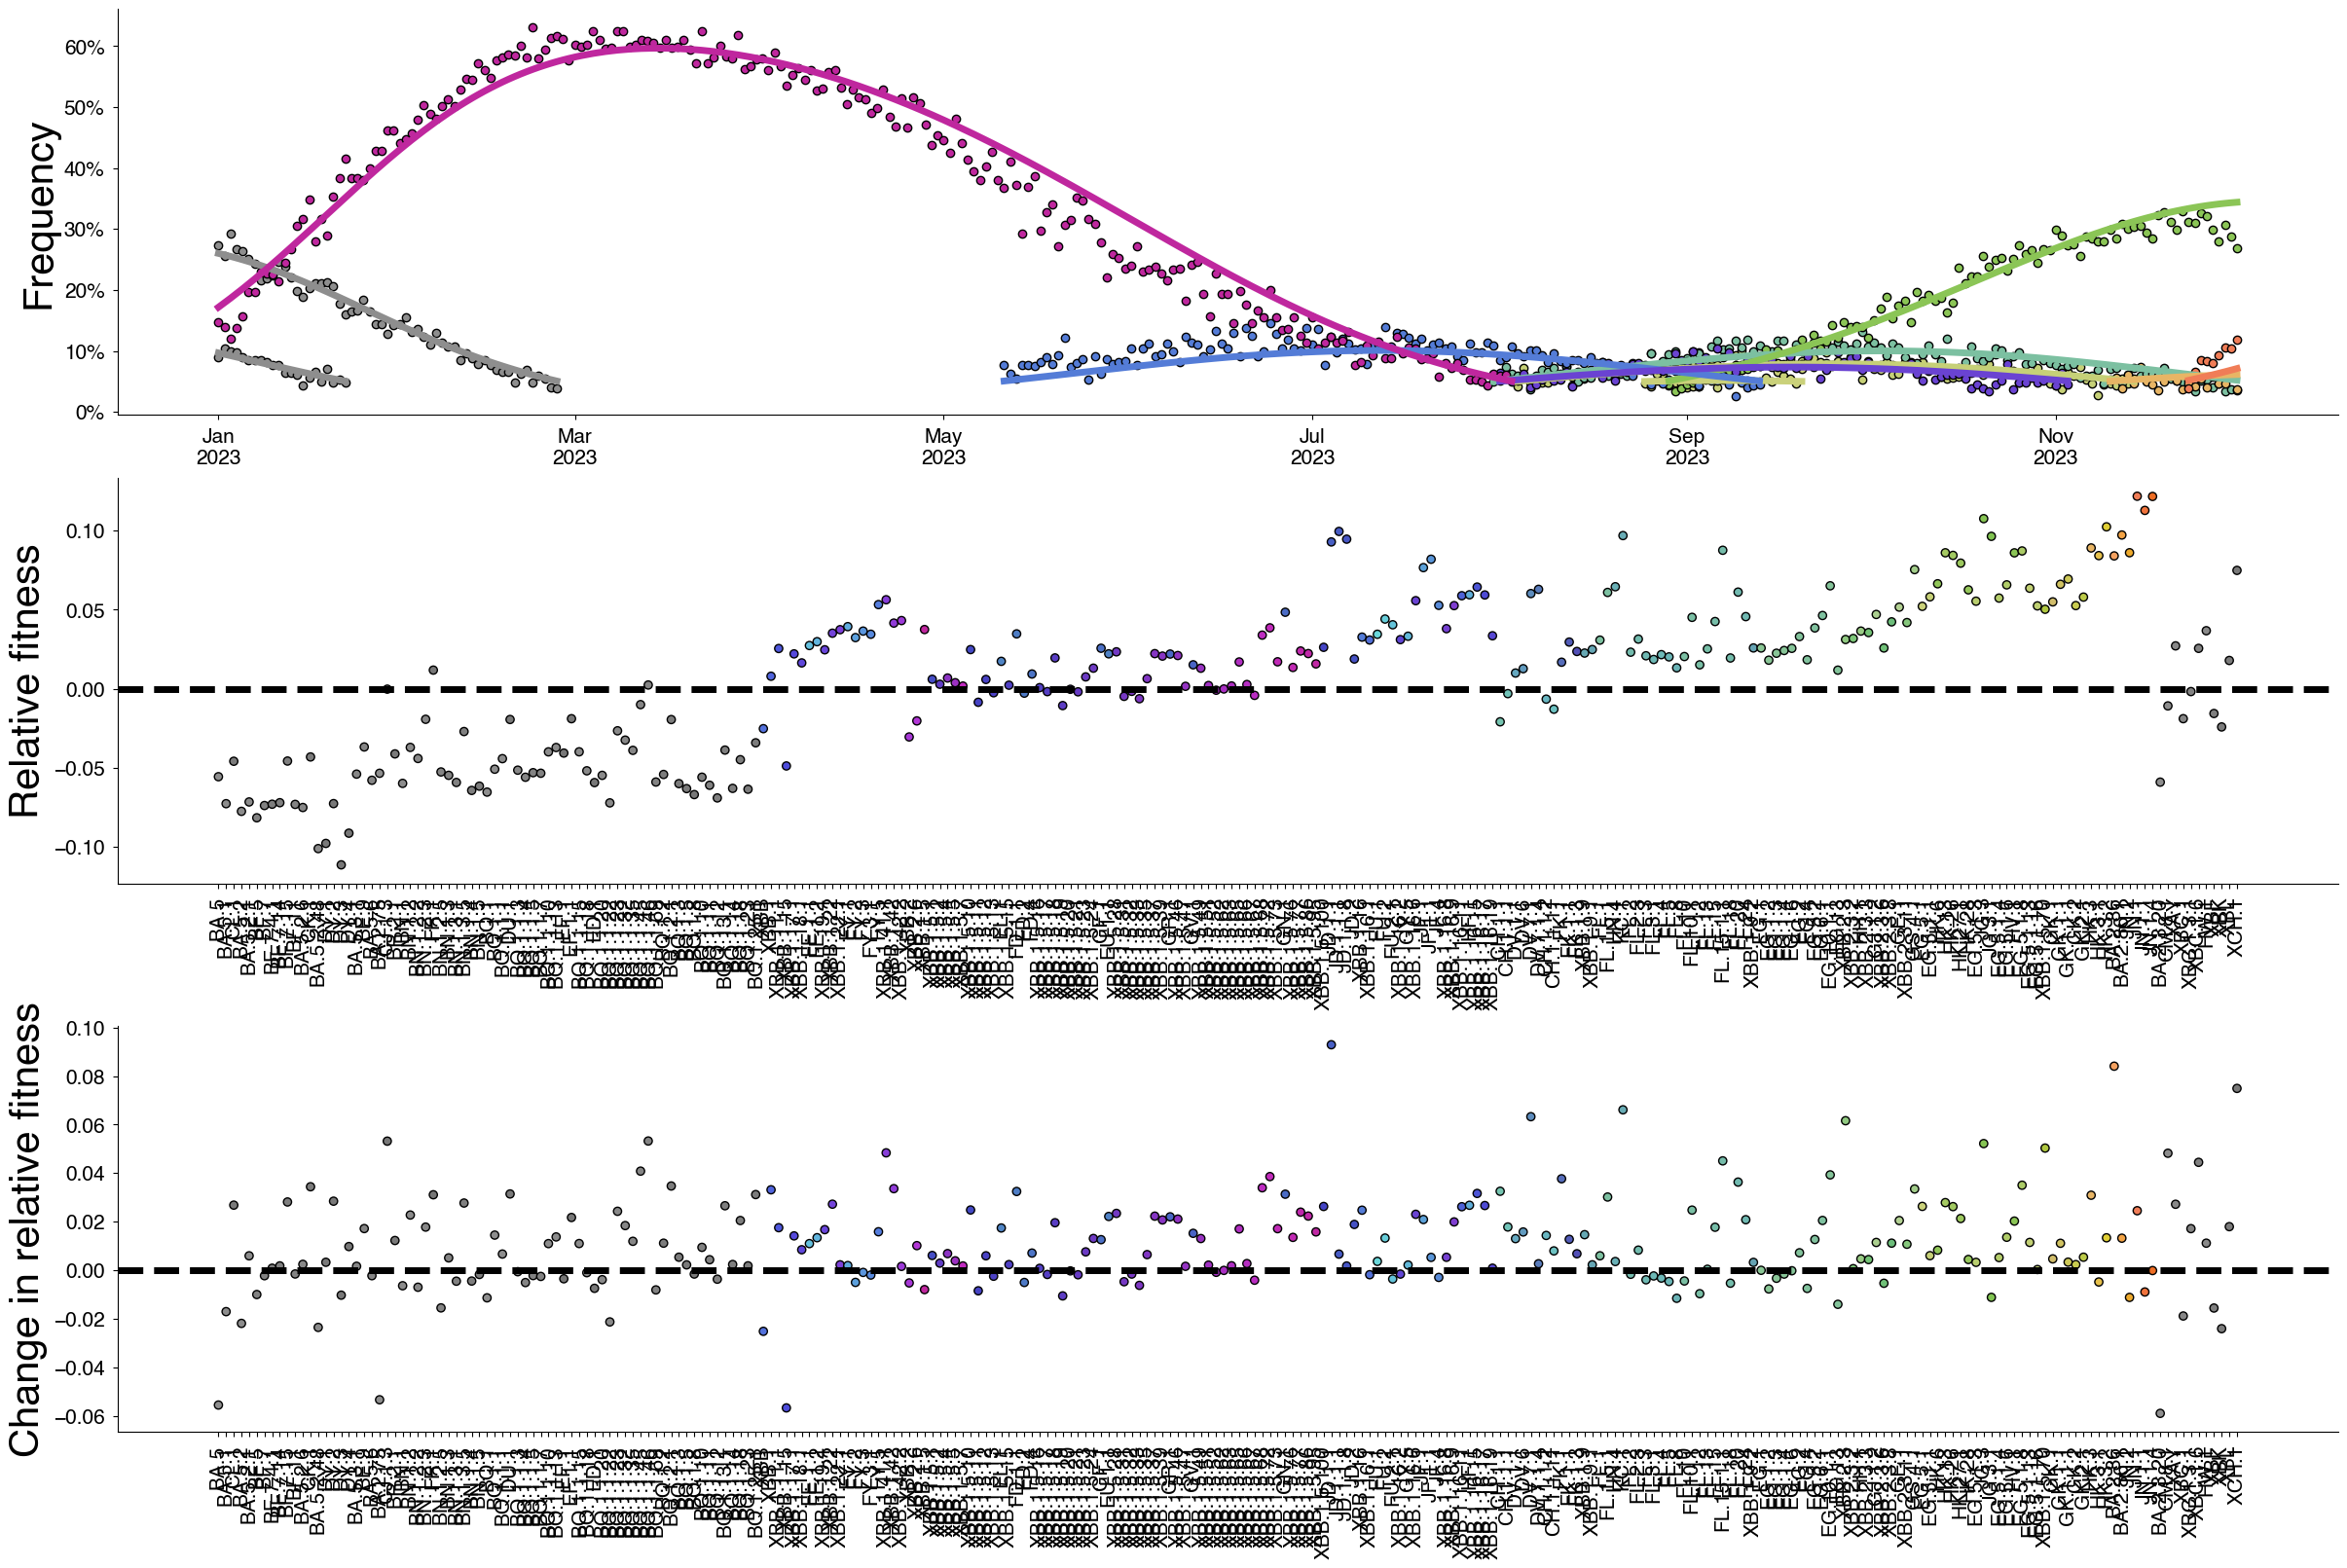

In [15]:
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize=(24., 16.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3)

# Add estimated frequency
FREQ_THRES = 0.05
ax = fig.add_subplot(spec[0, 0])
plot_estimated_frequency(ax, posterior, freq_thres=FREQ_THRES)
plot_raw_frequency(ax, posterior, freq_thres=FREQ_THRES)

# Add estimated growth advantage
ax = fig.add_subplot(spec[1, 0])
plot_relative_fitness(ax, posterior)

ax = fig.add_subplot(spec[2, 0])
plot_relative_fitness_innovation(ax, posterior)

265


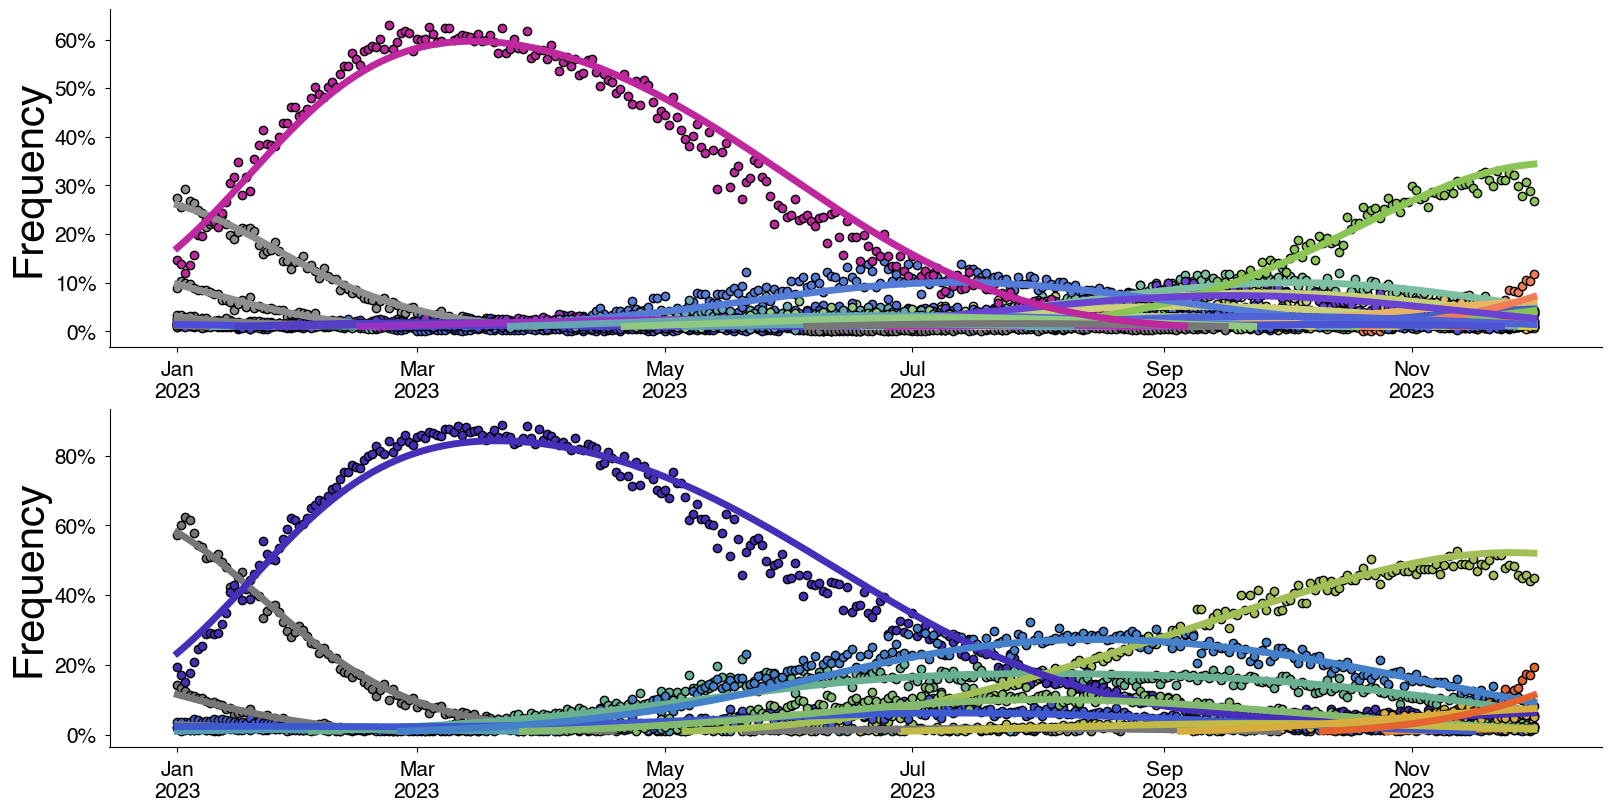

In [16]:

def plot_clade_collapsed_frequency(ax, posterior, clade_map, clade_color_map, freq_thres=None):
    """
    Plots clade-collapsed frequencies.

    Parameters:
        ax: Matplotlib Axes object where the plot will be drawn.
        posterior: Posterior object containing frequency samples and date information.
        clade_map: Dictionary mapping variants to their clades.
        clade_color_map: Dictionary mapping clades to their colors.
        freq_thres: Frequency threshold; only frequencies above this value are plotted.

    Returns:
        None
    """
    if freq_thres is None:
        freq_thres = 0.001

    # Map each clade to its indices in the posterior samples
    var_names = posterior.data.var_names
    print(len(var_names))
    clade_indices = {}
    for variant in var_names:
        clade = clade_map.get(variant, "other")
        if clade not in clade_indices:
            clade_indices[clade] = []
        clade_indices[clade].append(var_names.index(variant))

    # Sum frequencies for each clade and plot
    for clade, indices in clade_indices.items():
        # Sum frequencies across all variants belonging to the same clade
        clade_frequencies = np.sum(posterior.samples["freq"][0, :, indices], axis=0)

        # Only include times when clade frequency exceeds threshold
        included = clade_frequencies > freq_thres
        
        ax.plot(
            np.array(posterior.data.dates)[included],
            clade_frequencies[included],
            color=clade_color_map.get(clade, "gray"),  # Default to gray if clade not in color map
            label=clade
        )

    # Format the plot
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    #ax.legend(title="Clades", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    return None

def plot_clade_collapsed_raw_frequency(ax, posterior, clade_map, clade_color_map, freq_thres=None):
    """
    Plots clade-collapsed raw frequencies.

    Parameters:
        ax: Matplotlib Axes object where the plot will be drawn.
        posterior: Posterior object containing frequency samples, date information, and sequence counts.
        clade_map: Dictionary mapping variants to their clades.
        clade_color_map: Dictionary mapping clades to their colors.
        freq_thres: Frequency threshold; only frequencies above this value are plotted.

    Returns:
        None
    """
    if freq_thres is None:
        freq_thres = 0.001

    # Calculate raw frequencies from sequence counts
    seq_counts = posterior.data.seq_counts
    raw_freqs = seq_counts / seq_counts.sum(axis=-1)[:, None]

    # Map each clade to its indices in the sequence counts
    var_names = posterior.data.var_names
    clade_indices = {}
    for variant in var_names:
        clade = clade_map.get(variant, "other")
        if clade not in clade_indices:
            clade_indices[clade] = []
        clade_indices[clade].append(var_names.index(variant))

    # Sum raw frequencies for each clade and plot
    for clade, indices in clade_indices.items():
        clade_raw_frequencies = np.sum(raw_freqs[:, indices], axis=1)
        
        # Only include times when clade frequency exceeds threshold
        included = clade_raw_frequencies > freq_thres
        ax.scatter(
            np.array(posterior.data.dates)[included],
            clade_raw_frequencies[included],
            color=clade_color_map.get(clade, "gray"),  # Default to gray if clade not in color map
            edgecolor="k",
            label=clade
        )

    # Format the plot
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    #ax.legend(title="Clades", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    return None

fig = plt.figure(figsize=(16., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

# Add estimated frequency
FREQ_THRES = 0.01
ax = fig.add_subplot(spec[0, 0])
plot_estimated_frequency(ax, posterior, freq_thres=FREQ_THRES)
plot_raw_frequency(ax, posterior, freq_thres=FREQ_THRES)

# Add estimated growth advantage
ax = fig.add_subplot(spec[1, 0])
plot_clade_collapsed_frequency(ax, posterior, clade_map, clade_color_map, freq_thres=FREQ_THRES)
plot_clade_collapsed_raw_frequency(ax, posterior, clade_map, clade_color_map, freq_thres=FREQ_THRES)

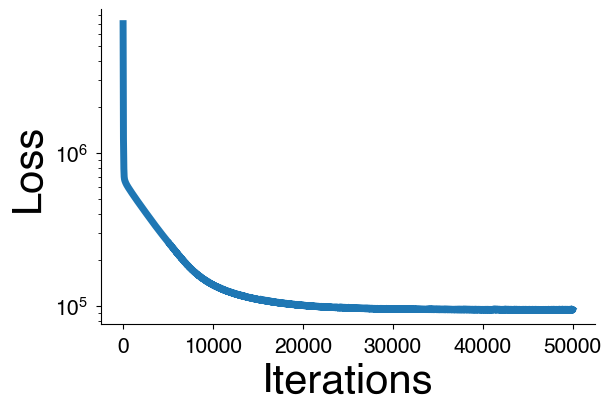

In [17]:
if "losses" in posterior.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [18]:
predictors = pd.read_csv(f"../data/{ANALYSIS}/phenotypes/lineage_phenotypes.csv")
predictors

lineage  ... Hamming distance relative to XBB.1.5
0          A  ...                                   42
1        A.1  ...                                   42
2        A.2  ...                                   42
3      A.2.2  ...                                   42
4      A.2.3  ...                                   42
...      ...  ...                                  ...
3908      XU  ...                                   15
3909      XV  ...                                   19
3910      XW  ...                                   15
3911      XY  ...                                   15
3912      XZ  ...                                   15

[3913 rows x 19 columns]

In [25]:
predictors = pd.read_csv(f"../data/{ANALYSIS}/phenotypes/lineage_phenotypes.csv")
#predictor_names = [
#                   "spike pseudovirus DMS Non-RBD spike mediated entry relative to XBB.1.5",
#                   "spike pseudovirus DMS Non-RBD ACE2 binding relative to XBB.1.5",
#                   "spike pseudovirus DMS Non-RBD human sera escape relative to XBB.1.5",
#                   "RBD yeast-display DMS escape relative to XBB.1.5", 
#                   "RBD yeast-display DMS ACE2 affinity relative to XBB.1.5",
#                   "RBD yeast-display DMS RBD expression relative to XBB.1.5",
#                   "number spike rbd muts from Wuhan-Hu-1",
#                   "EVEscape relative to XBB.1.5"]

predictors["number spike muts from XBB.1.5"] =[len(str(x).split()) for x in predictors["spike muts from XBB.1.5"]]
predictor_names = ["spike pseudovirus DMS human sera escape relative to XBB.1.5",
                   "spike pseudovirus DMS ACE2 binding relative to XBB.1.5",
                   "RBD yeast-display DMS ACE2 affinity relative to XBB.1.5",
                   "RBD yeast-display DMS RBD expression relative to XBB.1.5",
                   "RBD yeast-display DMS escape relative to XBB.1.5",]
                   #"EVEscape relative to XBB.1.5",
                   #"number spike muts from XBB.1.5"]

def prep_predictors(predictors, data, predictor_names):
    # Index by variant name
    #predictors = predictors.rename(columns={"clade": "variant"}).set_index("variant")
    predictors = predictors.rename(columns={"lineage": "variant"}).set_index("variant")
    predictors = (predictors
                     .replace("?")
                     .astype({name: "float" for name in predictor_names}))
    
    # Find scores of interest and parents
    var_names = [v for v in data.var_names if v in predictors.index]
    predictors = predictors.loc[var_names] # Need all variants to be present...
    predictors["parent"] = predictors.index.map(data.parent_map)
    
    # Get delta between parents and children
    def get_parent_delta(x, col="immune_escape"):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in predictors.index:
            return predictors.loc[variant][col] - predictors.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    for name in predictor_names:
        predictors[f"delta_{name}"] = predictors.apply(lambda x: get_parent_delta(x, name), axis=1)        
    return predictors

predictors = prep_predictors(predictors, data, predictor_names)
predictors

date  ... delta_RBD yeast-display DMS escape relative to XBB.1.5
variant                ...                                                       
BA.2.3.20  2022-09-02  ...                                                NaN    
BA.2.75    2022-06-24  ...                                                NaN    
BA.2.86    2023-08-17  ...                                                NaN    
BA.2.86.1  2023-09-05  ...                                                0.0    
BA.5       2022-04-06  ...                                                NaN    
...               ...  ...                                                ...    
XBF        2022-11-03  ...                                                NaN    
XBK        2022-12-15  ...                                                NaN    
XBL        2023-01-09  ...                                                NaN    
XCH.1      2023-08-30  ...                                                NaN    
XBB.1.5    2022-11-08  ...                                                NaN    

[261 rows x 24 columns]

In [26]:
from sklearn.linear_model import LinearRegression

def add_regression(ax, raw_x, raw_y, show_r_square=True):   
    
    # Processing data
    is_x_obs = ~np.isnan(raw_x) # Find where nan
    
    # Reshape data for input
    x = raw_x[is_x_obs].reshape((-1,1))
    y = raw_y[is_x_obs]
    
    # Define and fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    
    # Compute R^2
    r_square = model.score(x, y)
     
    # Plot line of axis
    y_pred = model.predict(x)
    
    ax.plot(x, y_pred, color="k")
    
    if show_r_square:
        ax.text(0.05, 0.95, fr"$R^2$: {np.round(r_square, 2)}", 
                horizontalalignment='left', 
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize=36)
    
    return model, r_square

def plot_single_regression(ax, predictor, outcome, xlabel=None, ylabel=None, color=None, s=None):
    ax.scatter(predictor, outcome,
               ec = "k",
               color="w" if color is None else color,
               s= 120 if s is None else s)
    add_regression(ax, predictor, outcome)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

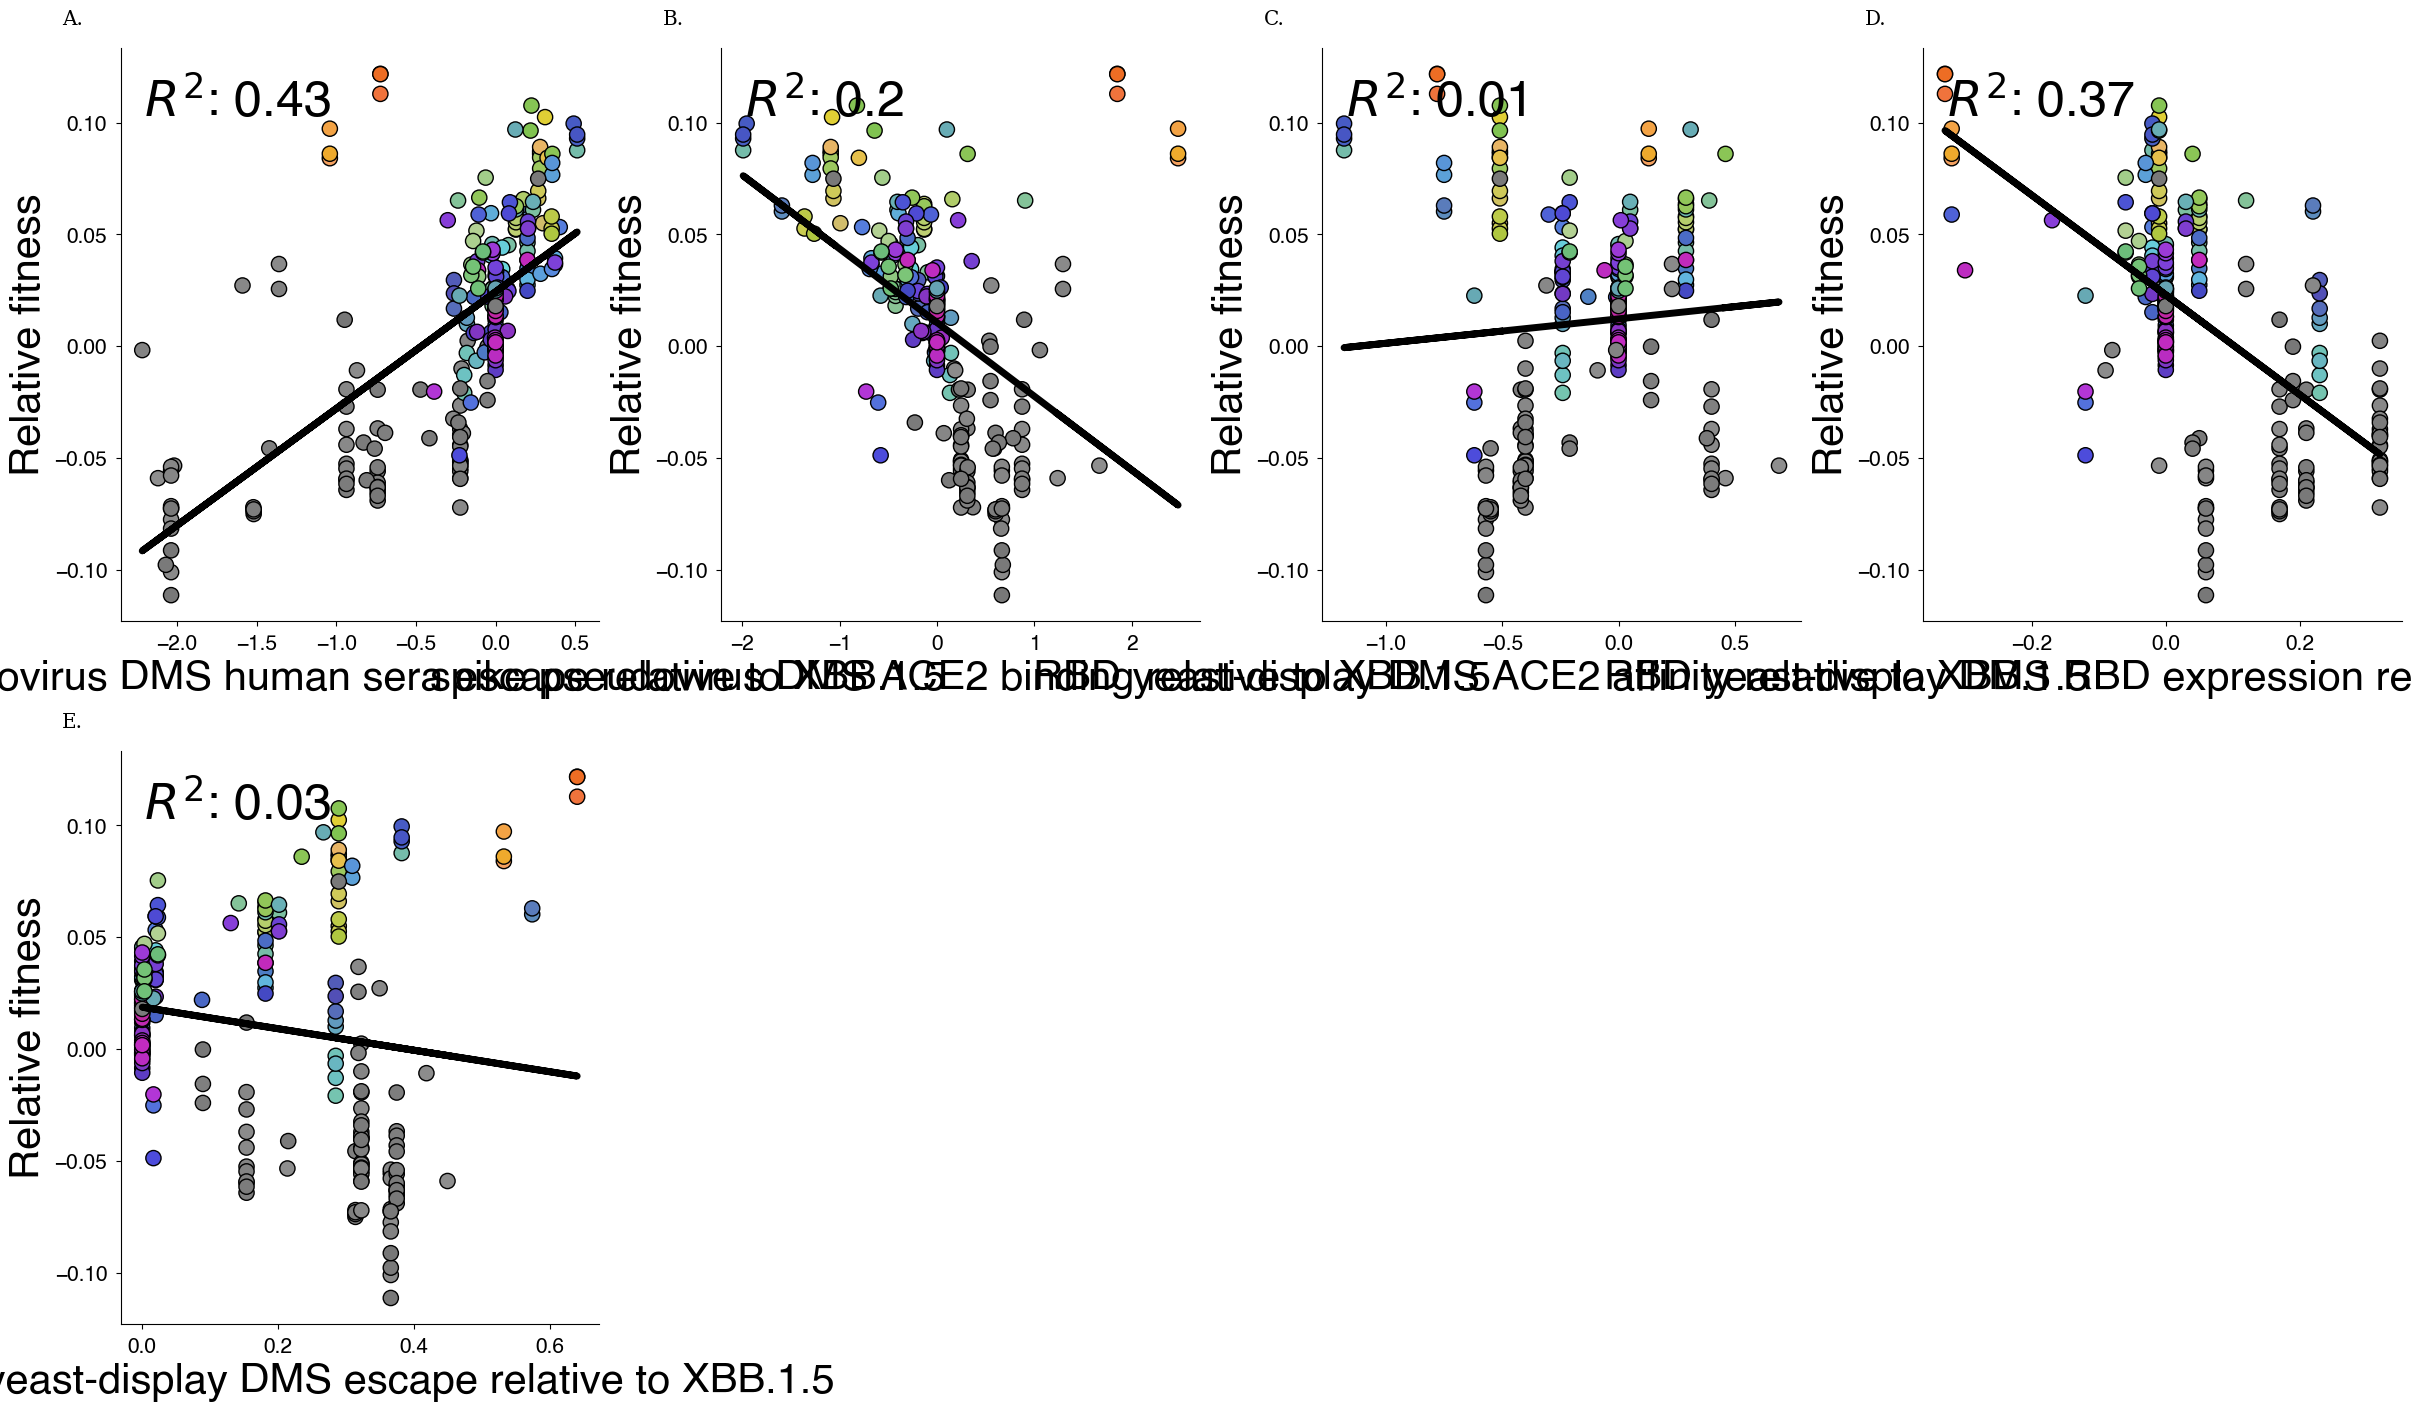

In [27]:
fig = plt.figure(figsize=(24, 14),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4)

# Defining growth advantage innovation
df = predictors.reset_index().merge(ga_df, how="left")[:-1]
log_ga = np.log(df.median_ga.values)

# Loop over predictor increments and plot
axs = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p])
    plot_single_regression(ax, 
                          predictor = df[name].values, 
                          outcome = log_ga,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = name,
                          ylabel = "Relative fitness")
    axs.append(ax)
    
# Adding panel labels
labels = [ letter + "." for letter in string.ascii_uppercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

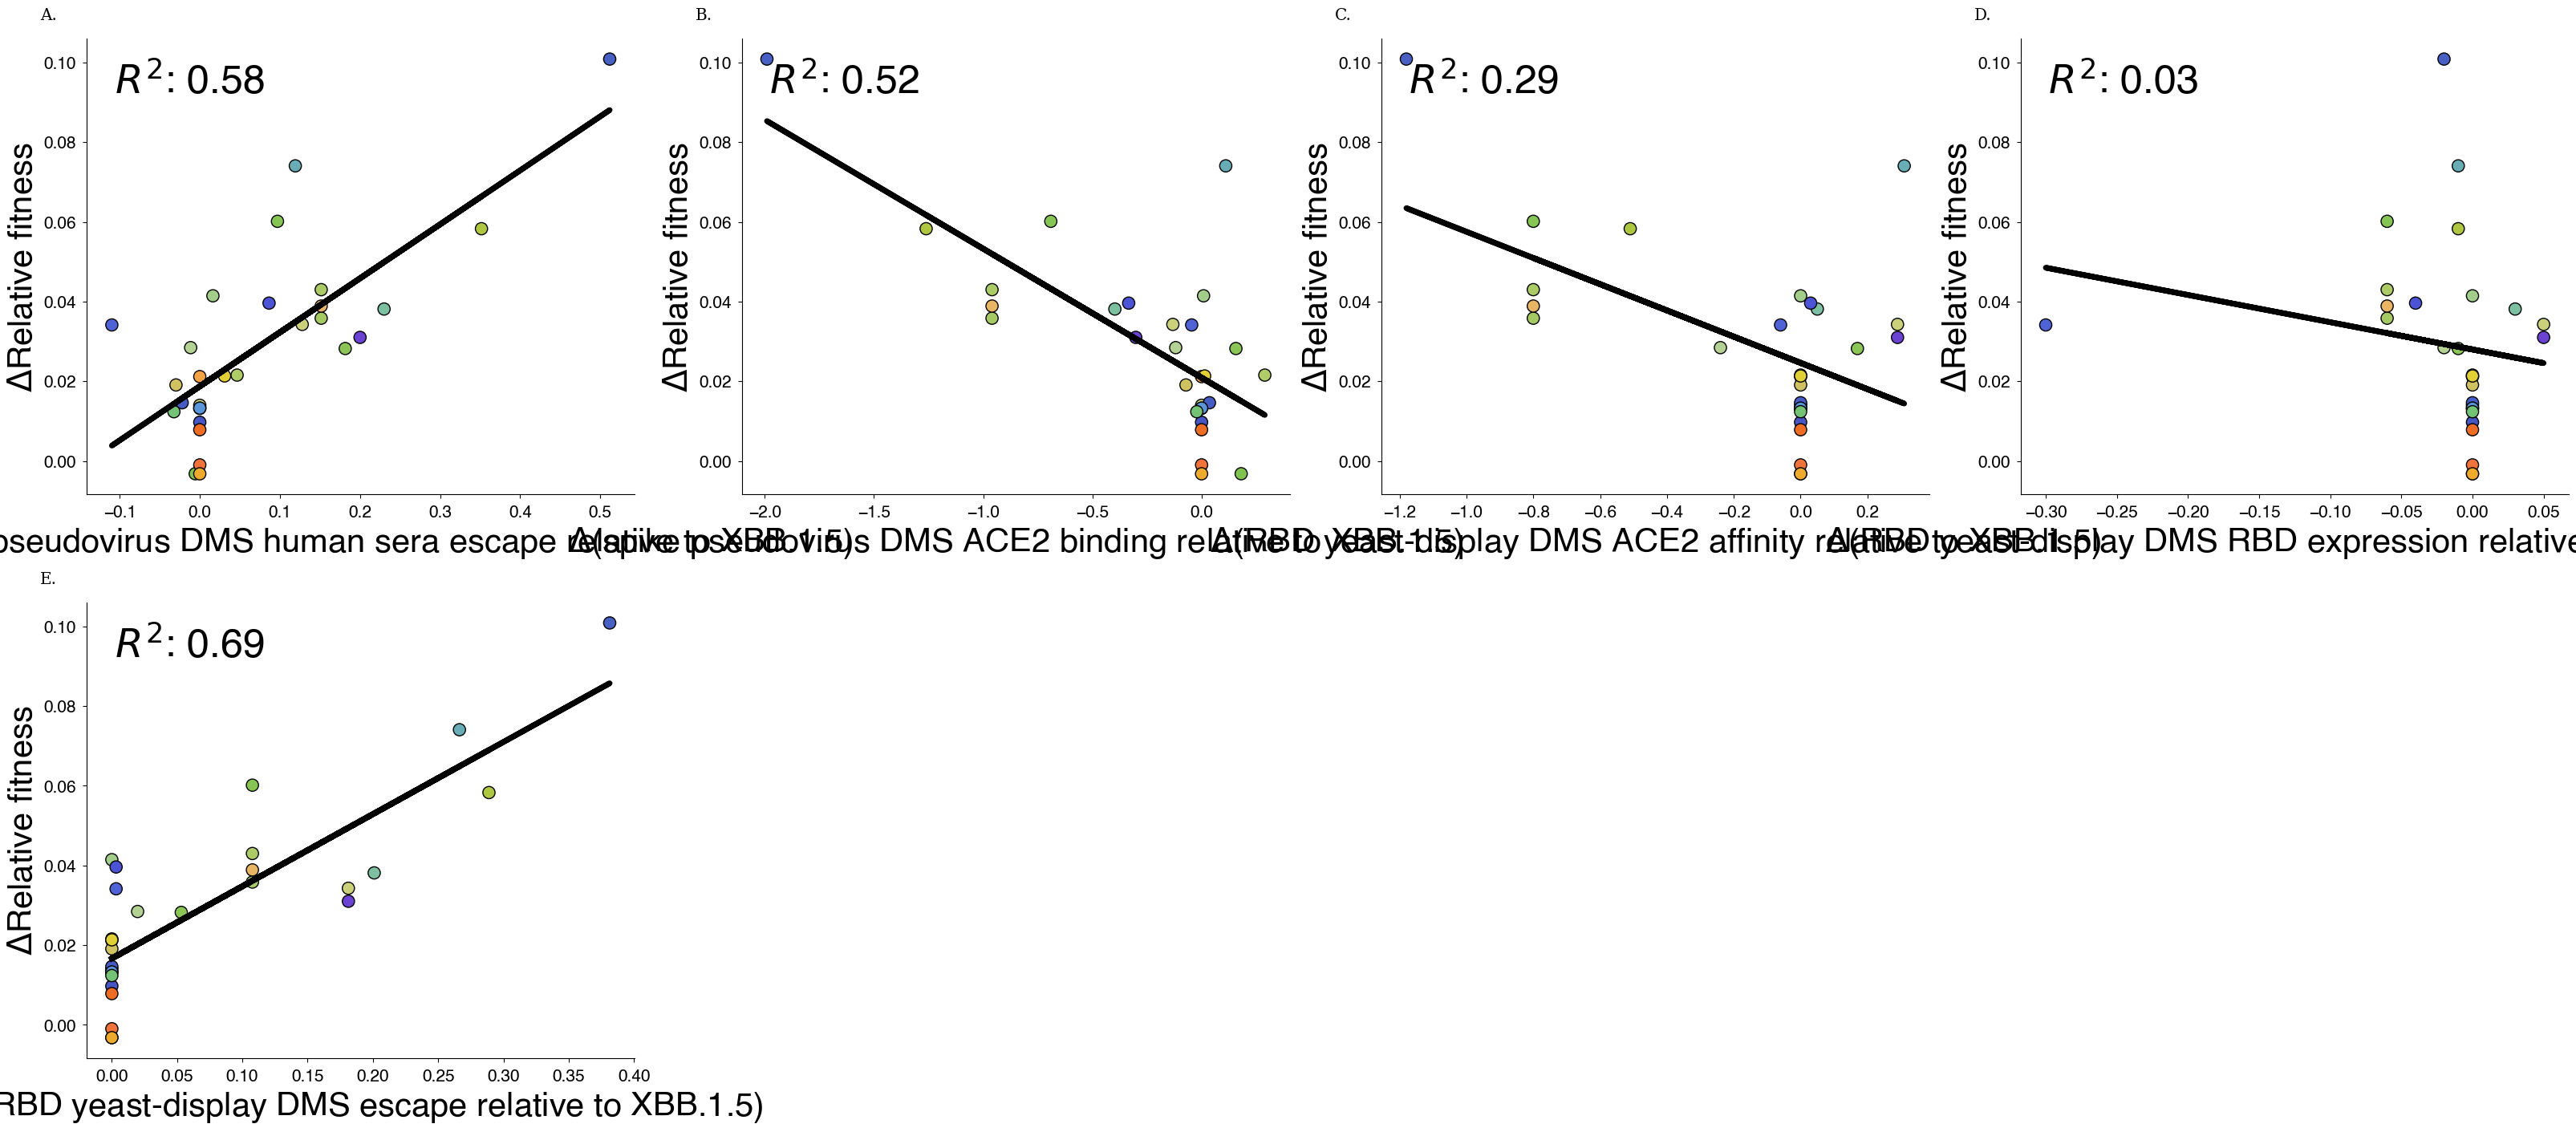

In [28]:
fig = plt.figure(figsize=(32, 14),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4)

# Defining growth advantage innovation
df = predictors.reset_index().merge(ga_delta_df, how="left")
df = df.dropna()
log_ga_delta = np.log(df.median_ga_delta.values)

# Loop over predictor increments and plot
axs = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p])
    plot_single_regression(ax, 
                          predictor = df["delta_"+name].values, 
                          outcome = log_ga_delta,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = rf"$\Delta$({name})",
                          ylabel = r"$\Delta$" + "Relative fitness")
    axs.append(ax)
    
# Adding panel labels
labels = [letter + "." for letter in string.ascii_uppercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [29]:
#fig.savefig("figures/delta-predictors-growth-advantage-innovation.png", facecolor="white")

In [30]:
def add_multi_regression(ax, raw_x, raw_y, show_r_square=True):   
    
    # Find and remove rows with nans
    is_x_obs = ~np.isnan(raw_x).any(axis=1) 
    x, y = raw_x[is_x_obs, :], raw_y[is_x_obs]
    
    # Define and fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    
    # Generate predictions
    y_pred = model.predict(x)

    # Compute R^2
    r_square = model.score(x, y) 
    if show_r_square:
        ax.text(0.05, 0.95, fr"$R^2$: {np.round(r_square, 2)}", 
                horizontalalignment='left', 
                verticalalignment='top',
                transform=ax.transAxes,
               fontsize=32)
        
    return model, y, y_pred, r_square

def plot_multiple_regression(ax, predictors, outcome, xlabel=None, ylabel=None, color=None):
    
    model, y_raw, y_pred, r_square = add_multi_regression(ax, predictors, outcome)
    ax.scatter(y_pred, outcome, ec = "k", color="w" if color is None else color, s=120)
    ax.plot(y_pred, y_pred, color="k", linestyle="--")
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    return model

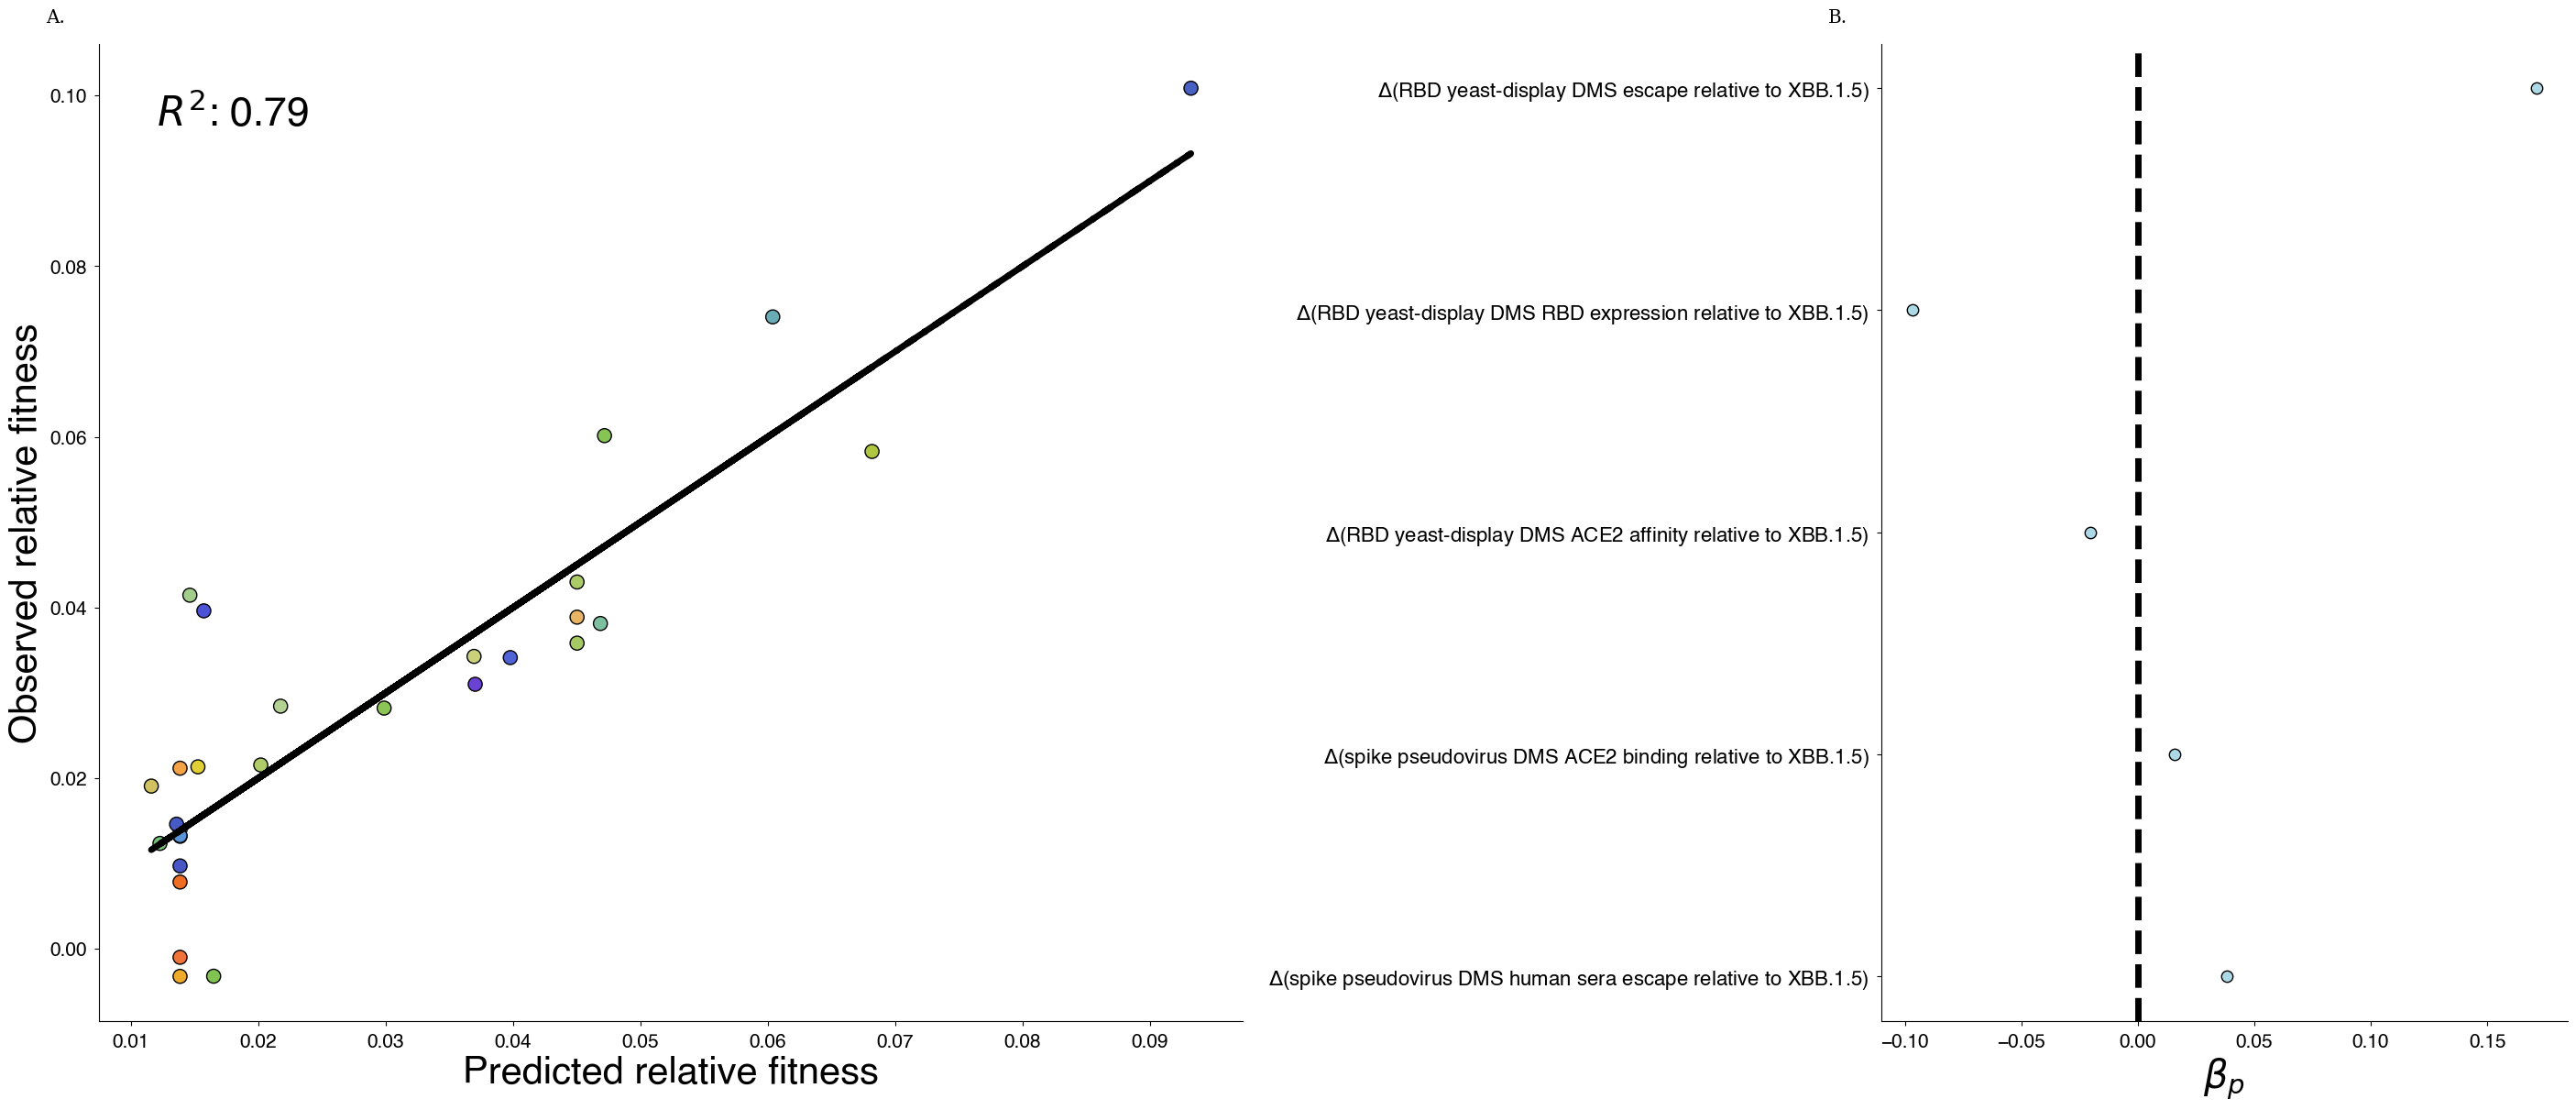

In [31]:
fig = plt.figure(figsize=(28, 12),  constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.0, 0.6])

# Prep predictors and outcome
df = predictors.reset_index().merge(ga_delta_df, how="left")[:-1]
df = df.dropna()
xs = df[["delta_" + name for name in predictor_names]].values
log_ga_delta = np.log(df.median_ga_delta.values)

# Add comparison between observed and predicted
ax_compare = fig.add_subplot(gs[0,0])
model = plot_multiple_regression(ax_compare, 
                                 predictors=xs, 
                                 outcome=log_ga_delta, 
                                 color=[color_map[v] for v in df["variant"].values],)

## Add diagonal for equality
ax_compare.set_xlabel("Predicted relative fitness")
ax_compare.set_ylabel("Observed relative fitness")

# Show parameter values
ax_betas = fig.add_subplot(gs[0,1])
betas = model.coef_
ind_betas = np.arange(len(betas))
ax_betas.scatter(betas, ind_betas, ec="k", color="lightblue", s=80)
ax_betas.axvline(0.0, color="k", linestyle="--")
ax_betas.set_yticks(ind_betas)
ax_betas.set_yticklabels([rf"$\Delta$({name})" for name in predictor_names], size=16)
ax_betas.set_xlabel(r"$\beta_{p}$")

# Adding panel labels
axs = [ax_compare, ax_betas]
labels = [letter + "." for letter in string.ascii_uppercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [32]:
#fig.savefig("figures/multi-delta-predictors-growth-advantage-innovation.png", facecolor="white")

In [33]:
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_pango_relationships(
    raw_variant_parents, 
    ax=None, 
    color_values=None, 
    color_map=None, 
    color_bar_label="",
    cmap="seismic"
):
    """
    Plot a partial phylogenetic tree from a DataFrame with flexible node coloring.

    Parameters:
        raw_variant_parents (pd.DataFrame): DataFrame with columns 'variant', 'parent_variant', and 'fitness'.
        ax (matplotlib.axes._axes.Axes): Matplotlib Axes object to draw the plot. If None, creates a new one.
        color_values (array-like): Array of numeric values to color nodes (e.g., fitness). If None, uses `color_map`.
        color_map (callable or dict): A mapping function or dictionary that maps variant names to colors. Ignored if `color_values` is provided.
        cmap (str): Matplotlib colormap to use for `color_values`.

    Returns:
        None
    """
    # Create a directed graph from the DataFrame
    tree = nx.DiGraph()
    for _, row in raw_variant_parents.iterrows():
        tree.add_node(row["variant"])
        if pd.notnull(row["parent"]):  # Avoid adding edges for root nodes
            tree.add_edge(row["parent"], row["variant"])

    # Layout the tree
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    pos = {node: (-y, x) for node, (x, y) in pos.items()}  # Flip for better visualization

    # Determine node colors
    if color_values is not None:
        # Case 1: Color nodes using `color_values` array
        node_colors = [color_values.get(node, np.nan) for node in tree.nodes]
        norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
        sm = ScalarMappable(cmap=cmap, norm=norm)
    elif color_map is not None:
        # Case 2: Color nodes using a `color_map` callable or dictionary
        if callable(color_map):
            node_colors = [color_map(node) for node in tree.nodes]
        elif isinstance(color_map, dict):
            node_colors = [color_map.get(node, "gray") for node in tree.nodes]
        else:
            raise ValueError("`color_map` must be a callable or dictionary.")
        sm = None
    else:
        raise ValueError("Either `color_values` or `color_map` must be provided.")

    # Plot the tree
    nx.draw(
        tree, pos, ax=ax, with_labels=False, node_size=120,
        edge_color="k", node_color=node_colors, edgecolors="k", cmap=cmap
    )

    # Add a color bar for `color_values`, if used
    if sm is not None:
        sm.set_array([])
        if ax:
            plt.colorbar(sm, ax=ax, label=color_bar_label)
    return None

/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


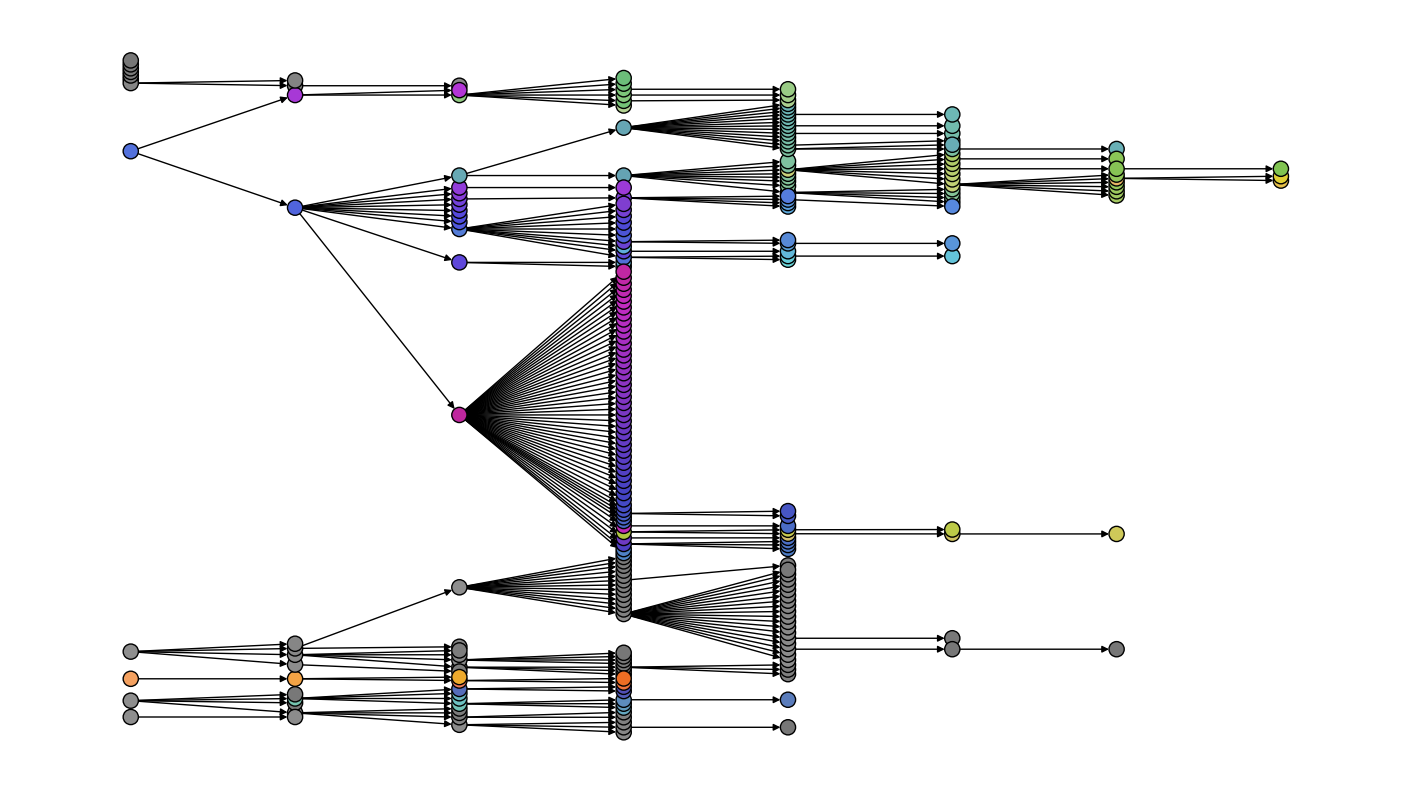

In [34]:
fig = plt.figure(figsize=(14, 8),  constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=1)

ax = fig.add_subplot(gs[0,0])
plot_pango_relationships(raw_variant_parents, ax=ax, color_map=color_map)

In [35]:
def plot_pango_relationships_temporal(
    raw_variant_parents, 
    ax=None, 
    time_values=None,
    color_values=None, 
    color_map=None, 
    cmap="viridis"
):
    """
    Plot a partial phylogenetic tree from a DataFrame with flexible node coloring and optional temporal information.

    Parameters:
        raw_variant_parents (pd.DataFrame): DataFrame with columns 'variant', 'parent', and optionally 'fitness'.
        ax (matplotlib.axes._axes.Axes): Matplotlib Axes object to draw the plot. If None, creates a new one.
        time_values (dict or None): Mapping of variant names to temporal values. Nodes without temporal values are skipped.
        color_values (dict or None): Mapping of variant names to numeric values for coloring (e.g., fitness). If None, uses `color_map`.
        color_map (callable or dict): A mapping function or dictionary that maps variant names to colors. Ignored if `color_values` is provided.
        cmap (str): Matplotlib colormap to use for `color_values`.

    Returns:
        None
    """
    # Create a directed graph from the DataFrame
    tree = nx.DiGraph()
    for _, row in raw_variant_parents.iterrows():
        # Skip nodes without temporal information if time_values is provided
        if time_values is not None and row["variant"] not in time_values:
            continue

        # Add node to the graph
        tree.add_node(
            row["variant"],
            value=color_values.get(row["variant"]) if color_values else None,
            time=time_values[row["variant"]] if time_values else None
        )
        if pd.notnull(row["parent"]) and (time_values is None or row["parent"] in time_values):
            tree.add_edge(row["parent"], row["variant"])

    # Layout the tree
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    if time_values is None:
        pos = {node: (-y, x) for node, (x, y) in pos.items()}
    else:
        pos = {
            node: (tree.nodes[node]["time"], x)
            for node, (x, y) in pos.items()
            if "time" in tree.nodes[node] and tree.nodes[node]["time"] is not None
        }

    # Determine node colors
    if color_values is not None:
        # Case 1: Use numeric `color_values` for node coloring
        node_values = [tree.nodes[node]["value"] for node in tree.nodes]
        norm = Normalize(vmin=min(node_values), vmax=max(node_values))
        node_colors = [tree.nodes[node]["value"] for node in tree.nodes]
        sm = ScalarMappable(cmap=cmap, norm=norm)
    elif color_map is not None:
        # Case 2: Use `color_map` callable or dictionary
        if callable(color_map):
            node_colors = [color_map(node) for node in tree.nodes]
        elif isinstance(color_map, dict):
            node_colors = [color_map.get(node, "gray") for node in tree.nodes]
        else:
            raise ValueError("`color_map` must be a callable or dictionary.")
        sm = None
    else:
        raise ValueError("Either `color_values` or `color_map` must be provided.")

    # Plot the tree
    nx.draw(
        tree, pos, ax=ax, with_labels=False, node_size=120,
        edge_color="k", node_color=node_colors, edgecolors="k", cmap=cmap
    )

    # Add a color bar for `color_values`, if used
    if sm is not None:
        sm.set_array([])
        if ax:
            plt.colorbar(sm, ax=ax, label="Node Color")
        else:
            plt.colorbar(sm, label="Node Color")

    # Add axis labels for temporal visualization
    if time_values is not None:
        ax.set_xlabel("Time")

    return None

In [36]:
def compute_days_since_first_appearance(data):
    """
    Compute the date of first appearance for each variant.

    Parameters:
        data (pd.DataFrame): A DataFrame containing columns 'date', 'variant', and 'sequences'.

    Returns:
        pd.DataFrame: A new DataFrame with columns 'variant' and 'first_appearance_date'.
    """
    # Create a copy to ensure the original data is not altered
    data_copy = data.copy()
    data_copy = data_copy[data_copy["sequences"] > 30]
 
    # Ensure the 'date' column is in datetime format
    data_copy["date"] = pd.to_datetime(data_copy["date"])

    # Compute the first appearance date for each variant
    first_appearance = data_copy.groupby("variant")["date"].min().reset_index()

    # Rename the columns for clarity
    first_appearance.columns = ["variant", "first_appearance_date"]
    base_date = first_appearance["first_appearance_date"].min()
    return first_appearance.set_index("variant")["first_appearance_date"].apply(lambda x: (x - base_date).days).to_dict() 

In [37]:
raw_seq

location    variant       date  sequences
8           USA  BA.2.3.20 2023-01-01          1
20          USA  BA.2.3.20 2023-01-02         10
34          USA  BA.2.3.20 2023-01-03          9
50          USA  BA.2.3.20 2023-01-04         10
63          USA  BA.2.3.20 2023-01-05          6
...         ...        ...        ...        ...
275995      USA      other 2023-11-27         22
276013      USA      other 2023-11-28         18
276031      USA      other 2023-11-29         14
276049      USA      other 2023-11-30         17
276066      USA      other 2023-12-01         23

[32393 rows x 4 columns]

/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


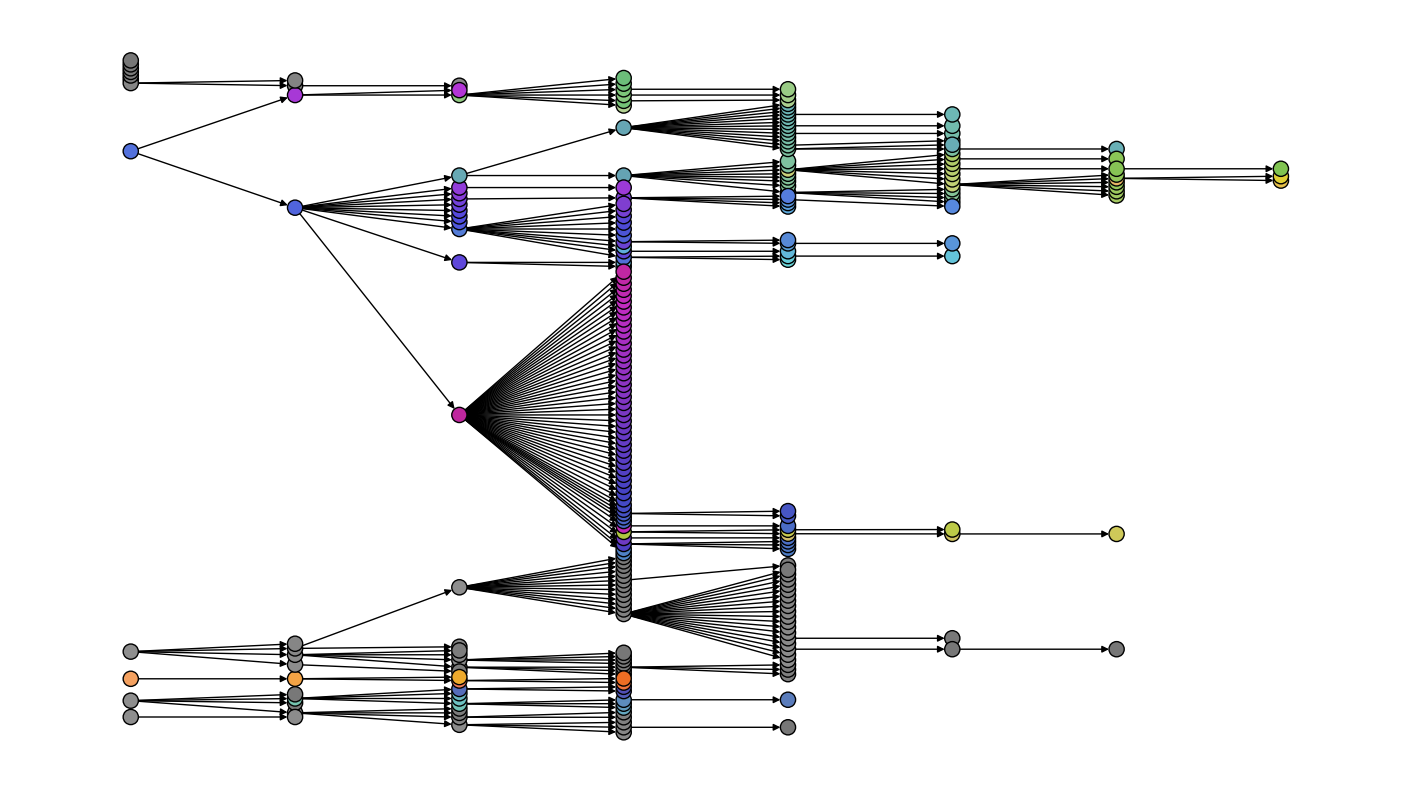

In [38]:
fig = plt.figure(figsize=(14, 8),  constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=1)

ax = fig.add_subplot(gs[0,0])


first_appearances = compute_days_since_first_appearance(raw_seq)


plot_pango_relationships_temporal(
    raw_variant_parents,
    ax=ax,
    color_map=color_map,
)

# COLOR BY CLADE
# COLOR BY DELTA ESCAPE

In [39]:
def plot_pango_relationships_temporal(
    raw_variant_parents, 
    ax=None, 
    time_values=None,
    color_values=None, 
    color_map=None, 
    cmap="viridis"
):
    """
    Plot a partial phylogenetic tree from a DataFrame with flexible node coloring and optional temporal information.

    Parameters:
        raw_variant_parents (pd.DataFrame): DataFrame with columns 'variant', 'parent', and optionally 'fitness'.
        ax (matplotlib.axes._axes.Axes): Matplotlib Axes object to draw the plot. If None, creates a new one.
        time_values (dict or None): Mapping of variant names to temporal values. Nodes without temporal values are skipped.
        color_values (dict or None): Mapping of variant names to numeric values for coloring (e.g., fitness). If None, uses `color_map`.
        color_map (callable or dict): A mapping function or dictionary that maps variant names to colors. Ignored if `color_values` is provided.
        cmap (str): Matplotlib colormap to use for `color_values`.

    Returns:
        None
    """
    # Create a directed graph from the DataFrame
    tree = nx.DiGraph()
    for _, row in raw_variant_parents.iterrows():
        # Skip nodes without temporal information if time_values is provided
        if time_values is not None and row["variant"] not in time_values:
            continue

        # Add node to the graph
        tree.add_node(
            row["variant"],
            value=color_values.get(row["variant"]) if color_values else None,
            time=time_values[row["variant"]] if time_values else None
        )
        
        if pd.notnull(row["parent"]) and (time_values is None or row["parent"] in time_values):
            # Ensure temporal consistency
            parent_time = time_values[row["parent"]] if row["parent"] in time_values else None
            child_time = time_values[row["variant"]] if row["variant"] in time_values else None

            if parent_time is not None and child_time is not None and child_time <= parent_time:
                print(f"Skipping edge: {row['parent']} -> {row['variant']} due to inconsistent time values.")
                continue  # Skip edges that would create loops
            
            tree.add_edge(row["parent"], row["variant"])

    # Layout the tree
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    if time_values is None:
        pos = {node: (-y, x) for node, (x, y) in pos.items()}
    else:
        # Only include nodes with a valid "time" attribute
        pos = {
            node: (tree.nodes[node]["time"], x)
            for node, (x, y) in pos.items()
            if "time" in tree.nodes[node] and tree.nodes[node]["time"] is not None
        }

    # Determine node colors
    if color_values is not None:
        # Case 1: Use numeric `color_values` for node coloring
        node_values = [tree.nodes[node]["value"] for node in tree.nodes]
        norm = Normalize(vmin=min(node_values), vmax=max(node_values))
        node_colors = [tree.nodes[node]["value"] for node in tree.nodes]
        sm = ScalarMappable(cmap=cmap, norm=norm)
    elif color_map is not None:
        # Case 2: Use `color_map` callable or dictionary
        if callable(color_map):
            node_colors = [color_map(node) for node in tree.nodes]
        elif isinstance(color_map, dict):
            node_colors = [color_map.get(node, "gray") for node in tree.nodes]
        else:
            raise ValueError("`color_map` must be a callable or dictionary.")
        sm = None
    else:
        raise ValueError("Either `color_values` or `color_map` must be provided.")

    # Plot the tree
    nx.draw(
        tree, pos, ax=ax, with_labels=False, node_size=220,
        edge_color="k", node_color=node_colors, edgecolors="k", cmap=cmap
    )

    # Add a color bar for `color_values`, if used
    if sm is not None:
        sm.set_array([])
        if ax:
            plt.colorbar(sm, ax=ax, label="Node Color")
        else:
            plt.colorbar(sm, label="Node Color")

    # Add axis labels for temporal visualization
    if time_values is not None:
        ax.set_xlabel("Time")
    ax.set_ylabel("Position (Hierarchical)")

    return None

Skipping edge: BA.5.2 -> BA.5.2.1 due to inconsistent time values.
Skipping edge: BA.5.2.1 -> BF.7 due to inconsistent time values.
Skipping edge: BA.5.3.1 -> BQ.1 due to inconsistent time values.
Skipping edge: BQ.1 -> BQ.1.1 due to inconsistent time values.
Skipping edge: EG.5.1.6 -> HV.1 due to inconsistent time values.
Skipping edge: BA.2.86.1 -> JN.1 due to inconsistent time values.
Skipping edge: XBB.1 -> XBB.1.15 due to inconsistent time values.
Skipping edge: XBB.1 -> XBB.1.5 due to inconsistent time values.


/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


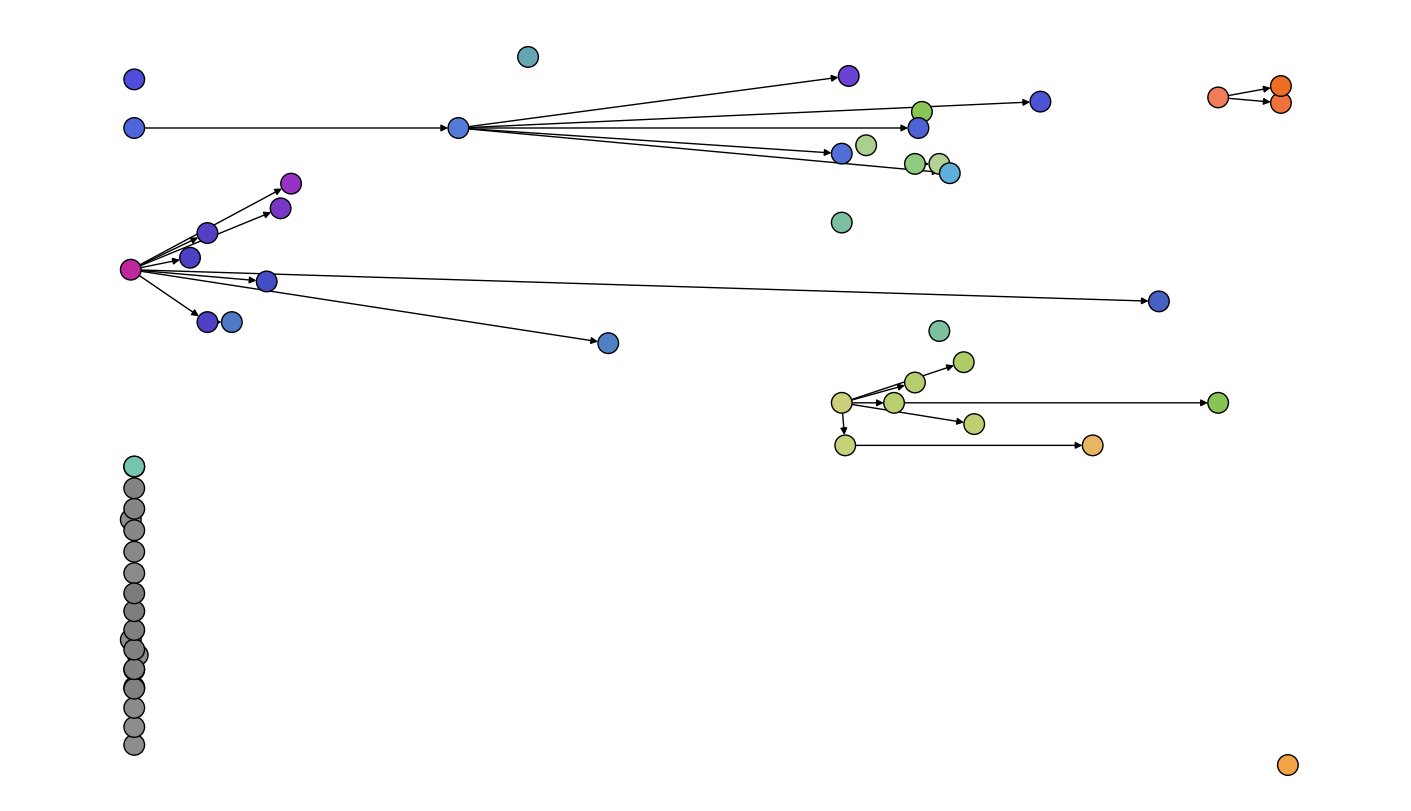

In [40]:
fig = plt.figure(figsize=(14, 8),  constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

first_appearances = compute_days_since_first_appearance(raw_seq)

plot_pango_relationships_temporal(
    raw_variant_parents,
    ax=ax,
    color_map=color_map,
    time_values = first_appearances
)


In [41]:
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

def plot_pango_relationships(
    raw_variant_parents, 
    ax=None, 
    color_values=None, 
    color_map=None, 
    color_bar_label="",
    cmap="seismic"
):
    """
    Plot a partial phylogenetic tree from a DataFrame with flexible node coloring.

    Parameters:
        raw_variant_parents (pd.DataFrame): DataFrame with columns 'variant', 'parent_variant', and 'fitness'.
        ax (matplotlib.axes._axes.Axes): Matplotlib Axes object to draw the plot. If None, creates a new one.
        color_values (array-like): Array of numeric values to color nodes (e.g., fitness). If None, uses `color_map`.
        color_map (callable or dict): A mapping function or dictionary that maps variant names to colors. Ignored if `color_values` is provided.
        cmap (str): Matplotlib colormap to use for `color_values`.

    Returns:
        None
    """
    # Create a directed graph from the DataFrame
    tree = nx.DiGraph()
    for _, row in raw_variant_parents.iterrows():
        tree.add_node(row["variant"])
        if pd.notnull(row["parent"]):  # Avoid adding edges for root nodes
            tree.add_edge(row["parent"], row["variant"])

    # Layout the tree
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    pos = {node: (-y, x) for node, (x, y) in pos.items()}  # Flip for better visualization

    # Determine node colors
    if color_values is not None:
        # Case 1: Color nodes using `color_values` array
        node_colors = [color_values.get(node, np.nan) for node in tree.nodes]
        norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
        sm = ScalarMappable(cmap=cmap, norm=norm)
    elif color_map is not None:
        # Case 2: Color nodes using a `color_map` callable or dictionary
        if callable(color_map):
            node_colors = [color_map(node) for node in tree.nodes]
        elif isinstance(color_map, dict):
            node_colors = [color_map.get(node, "gray") for node in tree.nodes]
        else:
            raise ValueError("`color_map` must be a callable or dictionary.")
        sm = None
    else:
        raise ValueError("Either `color_values` or `color_map` must be provided.")

    # Plot the tree
    nx.draw(
        tree, pos, ax=ax, with_labels=False, node_size=120,
        edge_color="k", node_color=node_colors, edgecolors="k", cmap=cmap
    )

    # Add a color bar for `color_values`, if used
    if sm is not None:
        sm.set_array([])
        if ax:
            plt.colorbar(sm, ax=ax, label=color_bar_label)
    return None

def add_clade_legend(ax, clade_map, clade_definitions, **kwargs):
    """
    Add a legend with color patches to a Matplotlib axis based on a clade_map.
    
    Parameters:
        ax: matplotlib.axes.Axes
            The axis to add the legend to.
        clade_map: dict
            A dictionary mapping clade names to color codes (e.g., {"Clade A": "#1f77b4"}).
        title: str, optional
            Title for the legend. Defaults to "Clades".
    """
    # Create color patches for the legend
    display_name_map = {entry["clade"]: entry["display_name"] for entry in clade_definitions}
    legend_patches = [Patch(color=color, label=display_name_map[clade]) for clade, color in clade_map.items()]
    ax.legend(handles=legend_patches, **kwargs)


265


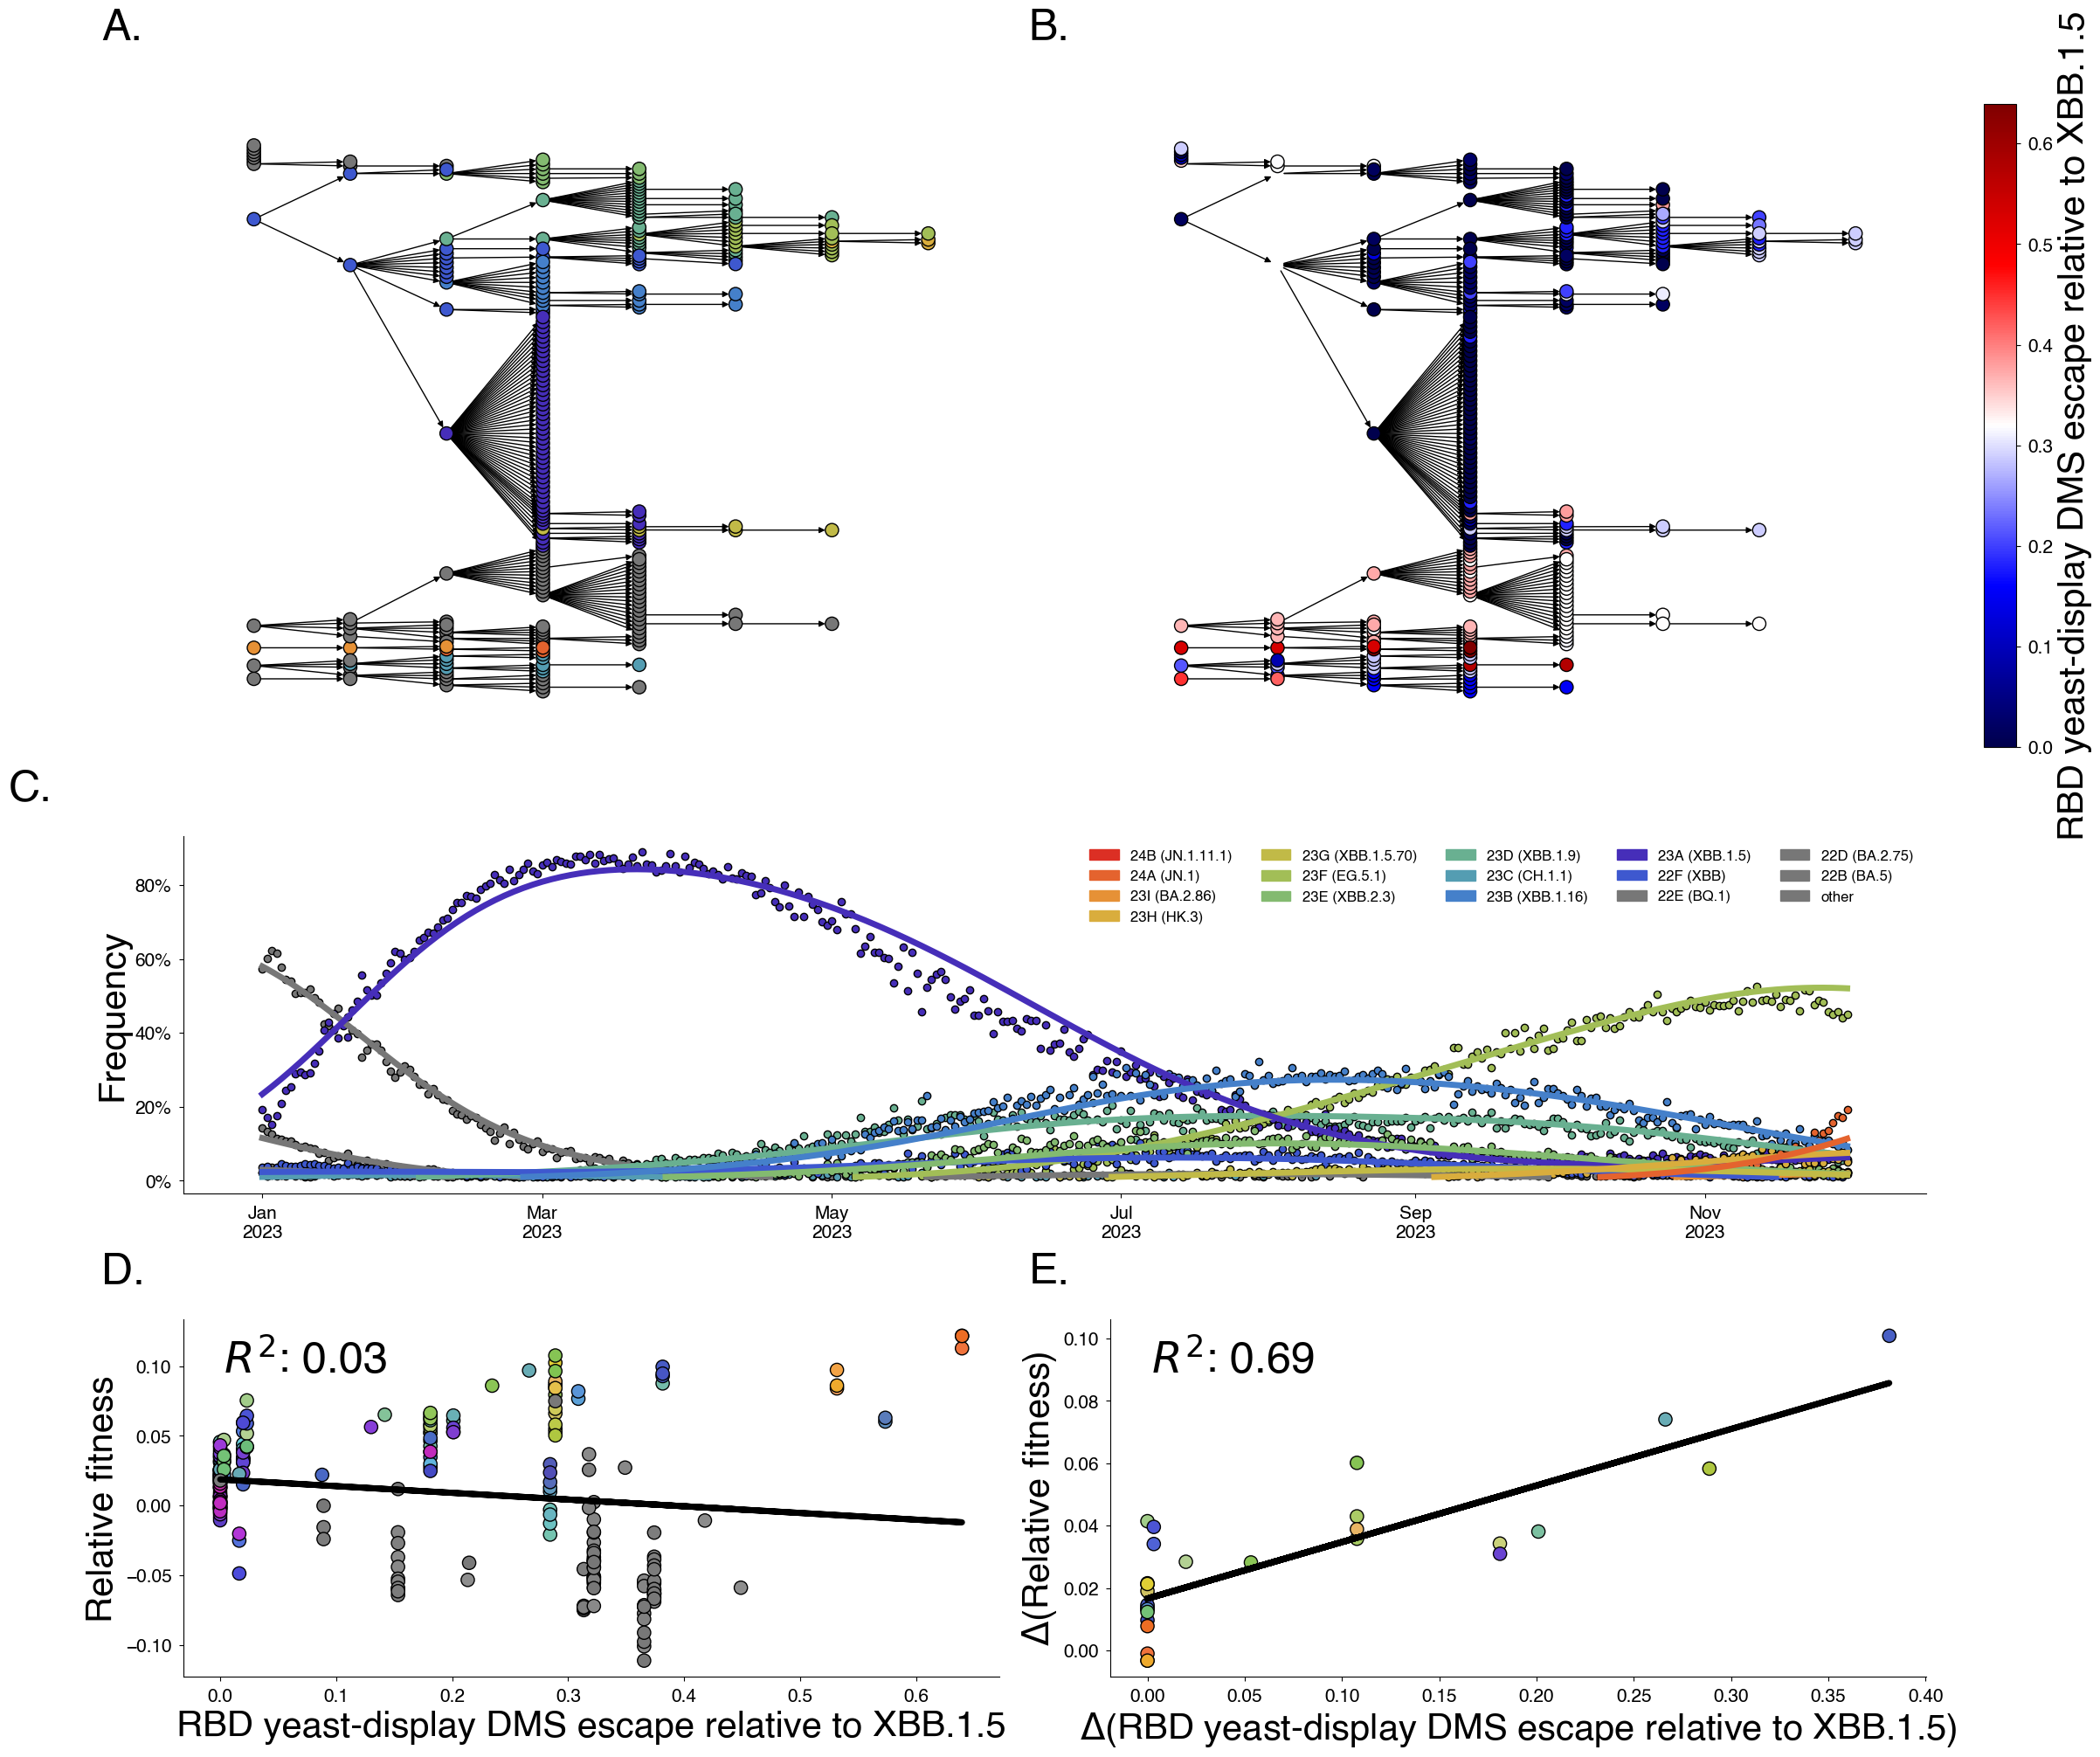

In [42]:
fig = plt.figure(figsize=(24, 20),  constrained_layout=True)
spec = fig.add_gridspec(nrows=3, ncols=4, height_ratios=[1.8, 1,1])

plot_val_col = "RBD yeast-display DMS escape relative to XBB.1.5"
plot_val_col_label = "Immune escape relative to XBB.1.5"
plot_val_col_label = plot_val_col

label_variants = ["XBB.1.5", "BA.2.86", "EG.5.1", "HK.3", "JN.1", ]

# Phylo by clade
ax_relationships_clade = fig.add_subplot(spec[0, 0:2])
plot_pango_relationships(raw_variant_parents,
                         ax=ax_relationships_clade,
                         color_map=color_map_by_clade
                        )
# TODO: Add labels for focal variants

# Plotting collapsed frequencies
ax_clade_collapsed_frequency = fig.add_subplot(spec[1, :])
plot_clade_collapsed_raw_frequency(ax_clade_collapsed_frequency, posterior, clade_map, clade_color_map, freq_thres=FREQ_THRES)
plot_clade_collapsed_frequency(ax_clade_collapsed_frequency, posterior, clade_map, clade_color_map, freq_thres=FREQ_THRES)

add_clade_legend(ax_clade_collapsed_frequency, clade_color_map, clade_definitions, 
                 loc="best", ncols=5, fontsize=12, frameon=False)

# Phylo by immune escape
ax_relationships_escape = fig.add_subplot(spec[0, 2:4])
color_values = predictors.to_dict()[plot_val_col]
plot_pango_relationships(raw_variant_parents,
                         ax=ax_relationships_escape,
                         color_values=color_values,
                        color_bar_label=plot_val_col_label)
# TODO: Add labels for focal variants

# Regression with escape
ax_regression_escape = fig.add_subplot(spec[2, 0:2])
df = predictors.reset_index().merge(ga_df, how="left")[:-1]
log_ga = np.log(df.median_ga.values)
plot_single_regression(ax_regression_escape, 
                          predictor = df[plot_val_col].values, 
                          outcome = log_ga,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = plot_val_col_label,
                          ylabel = "Relative fitness")

# Regression on innovations
ax_regression_escape_innovation = fig.add_subplot(spec[2, 2:4])
df = predictors.reset_index().merge(ga_delta_df, how="left")
df = df.dropna()
log_ga_delta = np.log(df.median_ga_delta.values)

# Loop over predictor increments and plot
plot_single_regression(ax_regression_escape_innovation, 
                          predictor = df["delta_" + plot_val_col].values, 
                          outcome = log_ga_delta,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = r"$\Delta$" + f"({plot_val_col_label})",
                          ylabel =r"$\Delta$" + "(Relative fitness)")

# Adding panel labels
axes = [ax_relationships_clade, ax_relationships_escape, ax_clade_collapsed_frequency, ax_regression_escape, ax_regression_escape_innovation]
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

In [43]:
fig.savefig("../manuscript/figures/interplay_phylo_escape_fitness.png")

In [44]:
def add_bracket(ax, start, end, label, y_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    y_offset : float, optional
        The vertical offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(start, y_offset), xytext=(end, y_offset),
                arrowprops=dict(arrowstyle='<|-|>', lw=3.0, **kwargs))
    ax.text((start + end) * 0.5, y_offset - height, label, fontsize=16, color=clade_color_map[label],
            ha='center', va='center', **kwargs)

def add_bracket_vertical(ax, start, end, label, x_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    x_offset : float, optional
        The horizontal offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(x_offset, start), xytext=(x_offset, end),
                arrowprops=dict(arrowstyle='<|-|>', lw=3.0, clip_on=False, **kwargs))
    ax.text(x_offset - height, (start + end) * 0.5, label, fontsize=14, color=clade_color_map[label],
            ha='center', va='center', rotation=90, **kwargs)
    
def add_clade_dividers(ax, reordered_clades, height=-0.4, x_offset=-0.55):
    current_clade = reordered_clades[0]
    start = 0

    for i in range(1, len(reordered_clades)):
        if reordered_clades[i] != current_clade:
            add_bracket_vertical(ax, start-0.5, i-0.5, current_clade, x_offset=x_offset, height=height)
            current_clade = reordered_clades[i]
            start = i
            
    # Add bracket for the last group
    add_bracket_vertical(ax, start - 0.5, len(reordered_clades)-1 + 0.5, current_clade, x_offset=x_offset, height=height)

In [45]:

def plot_relative_fitness_vertical(ax, posterior, thres=0.01):
    var_names = posterior.data.var_names
    n_vars = len(var_names)
    
    # Filter to only those who have reached certain frequency
    freq = np.array(posterior.samples["freq"][0, :, :-1])
    included = (freq >= thres).any(axis=0)[:-1]
    var_names_included = list(np.array(var_names[:-2])[included])
    n_vars_included = np.sum(included)
    
    # Get reordering
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names_included)    
    reordered_idx = np.array(reordered_idx)
    reordered_names = np.array(reordered_names)
    reordered_clades = np.array(reordered_clades)
    yticklabels_reordered = [var_names_included[r] for r in reordered_idx]
    
    add_clade_dividers(ax, reordered_clades)
    print(reordered_names)
    
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    
    ax.scatter(y=reordered_names,
               x=np.log(posterior.samples["ga"][0, :-1][included][reordered_idx]),
               color=[color_map[rn] for rn in reordered_names],
                s = 120, 
              ec="k")
    ax.set_yticks(np.arange(n_vars_included-1))
    ax.set_yticklabels(yticklabels_reordered)
    ax.set_xlabel("Relative fitness")
    ax.axvline(x=0.0, linestyle="--", color = "k")
    #for xtick in ax.get_xticklabels():
    #    xtick.set_color(color_map[xtick._text])
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)


# TODO: Change names
def plot_relative_fitness_innovation_vertical(ax, posterior, thres=0.01):
    var_names = posterior.data.var_names
    n_vars = len(var_names)
    
    # Filter to only those who have reached certain frequency
    freq = np.array(posterior.samples["freq"][0, :, :-1])
    included = (freq >= thres).any(axis=0)[:-1]
    var_names_included = list(np.array(var_names[:-2])[included])
    n_vars_included = np.sum(included)
    
    # Get reordering of filtered
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names_included)    
    reordered_idx = np.array(reordered_idx)
    reordered_names = np.array(reordered_names)
    reordered_clades = np.array(reordered_clades)
    yticklabels_reordered = [var_names_included[r] for r in reordered_idx]
    
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    
    ax.scatter(y=reordered_names,
               x=posterior.samples["delta"][0, :-2][included][reordered_idx],
               color=[color_map[rn] for rn in reordered_names],
               s = 120, 
              ec="k")
    ax.set_yticks(np.arange(n_vars_included-1))
    ax.set_yticklabels(yticklabels_reordered)
    ax.set_xlabel(r"$\Delta$" + "(Relative fitness)")
    ax.axvline(x=0.0, linestyle="--", color = "k")

    
def plot_innovation_distribution(ax, posterior):
    relative_fitness_innovation = posterior.samples["delta"][0, :]
    ax.hist(relative_fitness_innovation, color="lightgrey", bins=30, ec="k", density=True)
    ax.set_xlabel(r"$\Delta$" + "(Relative fitness)")

['BA.5.2' 'BQ.1' 'BQ.1.1' 'BQ.1.1.4' 'XBB.1.5.10' 'XBB.1.5.49' 'JD.1.1'
 'XBB.1.16' 'XBB.1.16.1' 'XBB.1.16.6' 'XBB.1.16.11' 'HF.1' 'XBB.1.9.1'
 'FL.1.5.1' 'XBB.2.3' 'GJ.1.2' 'EG.5.1' 'EG.5.1.1' 'EG.5.1.3' 'JG.3'
 'EG.5.1.4' 'EG.5.1.6' 'HV.1' 'HK.3' 'JN.1']


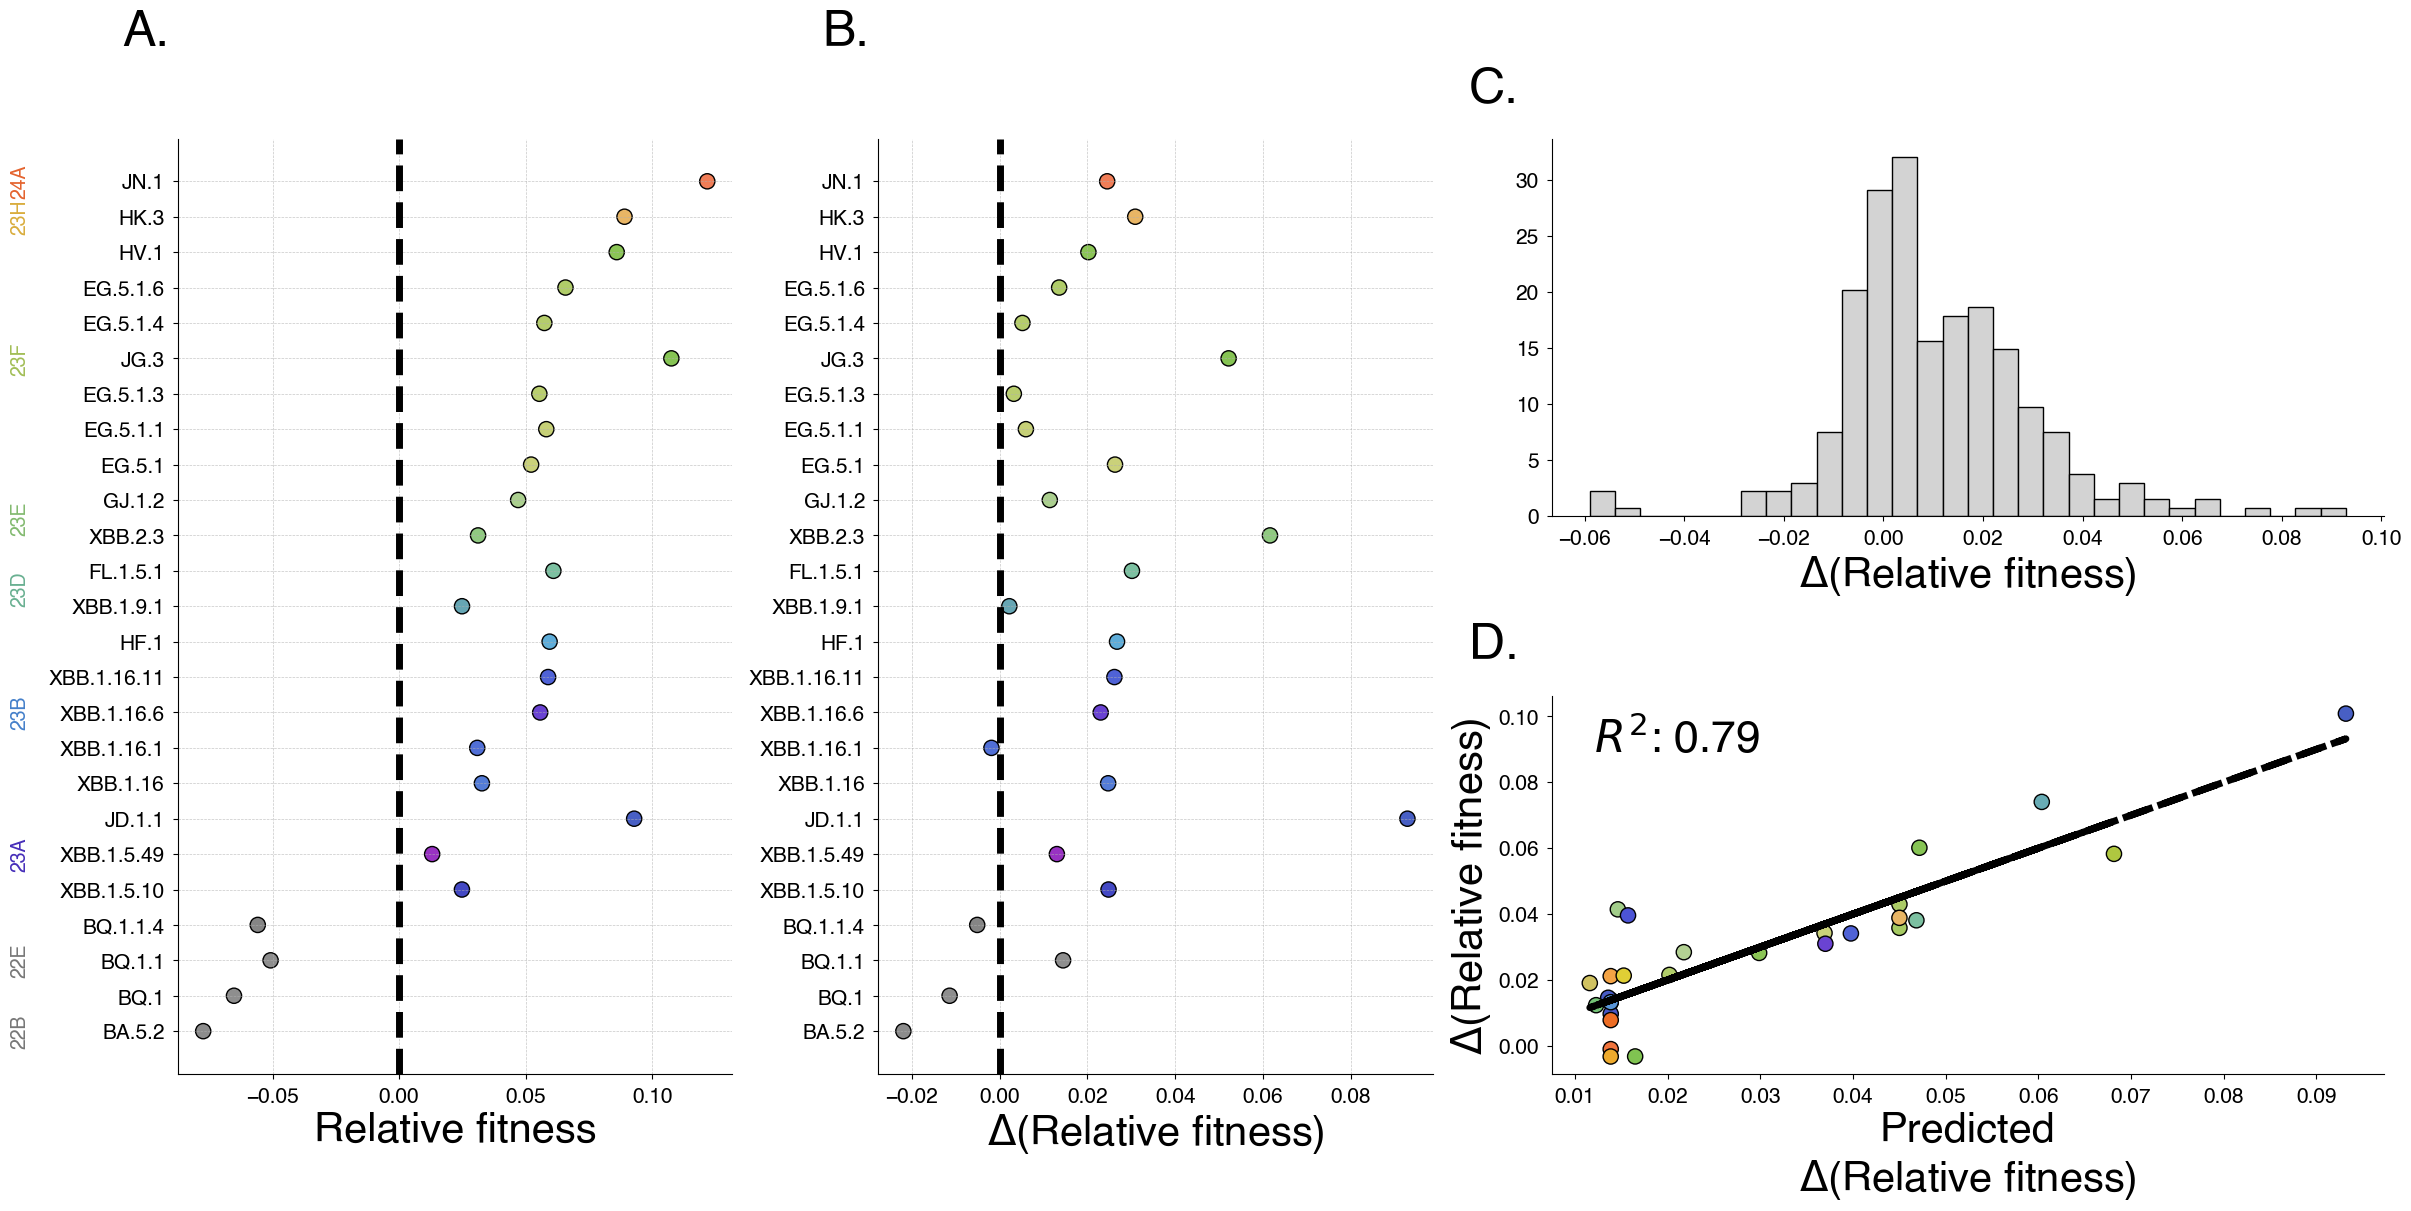

In [46]:
# Next figure estimating innovations!!
fig = plt.figure(figsize=(24, 12),  constrained_layout=True)
spec = fig.add_gridspec(nrows=4, ncols=3, width_ratios=[1,1,1.5])

freq_thres = 0.02

# A. Relative fitness
ax_relative_fitness = fig.add_subplot(spec[:, 0])
plot_relative_fitness_vertical(ax_relative_fitness, posterior, thres=freq_thres)

# B. Relative fitness delta
ax_relative_fitness_innovation = fig.add_subplot(spec[:, 1])
plot_relative_fitness_innovation_vertical(ax_relative_fitness_innovation, posterior, thres=freq_thres)

# C. Distribution of innovations
ax_innovation_distribution = fig.add_subplot(spec[0:2, 2])
plot_innovation_distribution(ax_innovation_distribution, posterior)

# D. Innovations in multiregression
ax_multiregression_innovation = fig.add_subplot(spec[2:4,2])

# Prep predictors and outcome
df = predictors.reset_index().merge(ga_delta_df, how="left")[:-1]
df = df.dropna()
xs = df[["delta_" + name for name in predictor_names]].values
log_ga_delta = np.log(df.median_ga_delta.values)

# Add comparison between observed and predicted
model = plot_multiple_regression(ax_multiregression_innovation, 
                                 predictors=xs, 
                                 outcome=log_ga_delta, 
                                 color=[color_map[v] for v in df["variant"].values],
                                 )
ax_multiregression_innovation.set_xlabel("Predicted\n" + r"$\Delta$" + "(Relative fitness)")
ax_multiregression_innovation.set_ylabel(r"$\Delta$" + "(Relative fitness)")




# Adding panel labels
axes = [ax_relative_fitness, ax_relative_fitness_innovation, ax_innovation_distribution, ax_multiregression_innovation]
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    

In [47]:
fig.savefig("../manuscript/figures/exploring-fitness-innovations.png")

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clade_innovation_violin(ax, posterior, clade_map, display_name_map, clade_colors):
    """
    Plot fitness innovations for each clade using half-violin plots with jittered points.

    Parameters:
        ax (matplotlib.axes._axes.Axes): Matplotlib axis to plot on.
        posterior: Object containing posterior samples, expected to have 'delta' key.
        clade_map (dict): Mapping from variant names to clades.
        display_name_map (dict): Mapping from internal clade names to display-friendly names.
        clade_colors (dict): Dictionary mapping clade names to specific colors.

    Returns:
        None: Plots the result directly on the provided axis.
    """
    # Extract fitness innovations
    relative_fitness_innovation = posterior.samples["delta"][0, :]
    
    # Create a DataFrame of variants, clades, and innovations
    variants = list(clade_map.keys())
    clades = [clade_map[variant] for variant in variants]
    display_clade_colors = {display_name_map.get(k, "Unknown"): v for k, v in clade_colors.items()}
    data = pd.DataFrame({
        "Variant": variants,
        "Clade": clades,
        "Innovation": relative_fitness_innovation
    })
    
    data["Clade_display"] = data["Clade"].map(display_name_map)
    
    # Filter out "other" or irrelevant clades
    data = data[data["Clade"] != "other"]
    
    # TODO: sort_by
    clade_order = list(data["Clade_display"].unique())
    clade_order.sort()
    
    # Plot the half-violin plot
    sns.violinplot(
        data=data,
        x="Clade_display",
        y="Innovation",
        hue="Clade_display",
        ax=ax,
       # inner=None,  # Remove inner boxplot
        linewidth=1.5,
        palette=display_clade_colors,
        cut=0,  # Avoid extending violins beyond the observed data range
        order=clade_order
    )
    
    # Overlay jittered points
    sns.stripplot(
        data=data,
        x="Clade_display",
        y="Innovation",
        ax=ax,
        color="k",
        alpha=0.7,
        jitter=True,
        size=3,
        order=clade_order
    )
    ax.axhline(y=0.0, lw=1, linestyle="--", color="k")
    # Set axis labels and style
    ax.set_ylabel(r"$\Delta$ (Relative fitness)")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

['BA.5.2' 'BQ.1' 'BQ.1.1' 'BQ.1.1.4' 'XBB.1.5.10' 'XBB.1.5.49' 'JD.1.1'
 'XBB.1.16' 'XBB.1.16.1' 'XBB.1.16.6' 'XBB.1.16.11' 'HF.1' 'XBB.1.9.1'
 'FL.1.5.1' 'XBB.2.3' 'GJ.1.2' 'EG.5.1' 'EG.5.1.1' 'EG.5.1.3' 'JG.3'
 'EG.5.1.4' 'EG.5.1.6' 'HV.1' 'HK.3' 'JN.1']


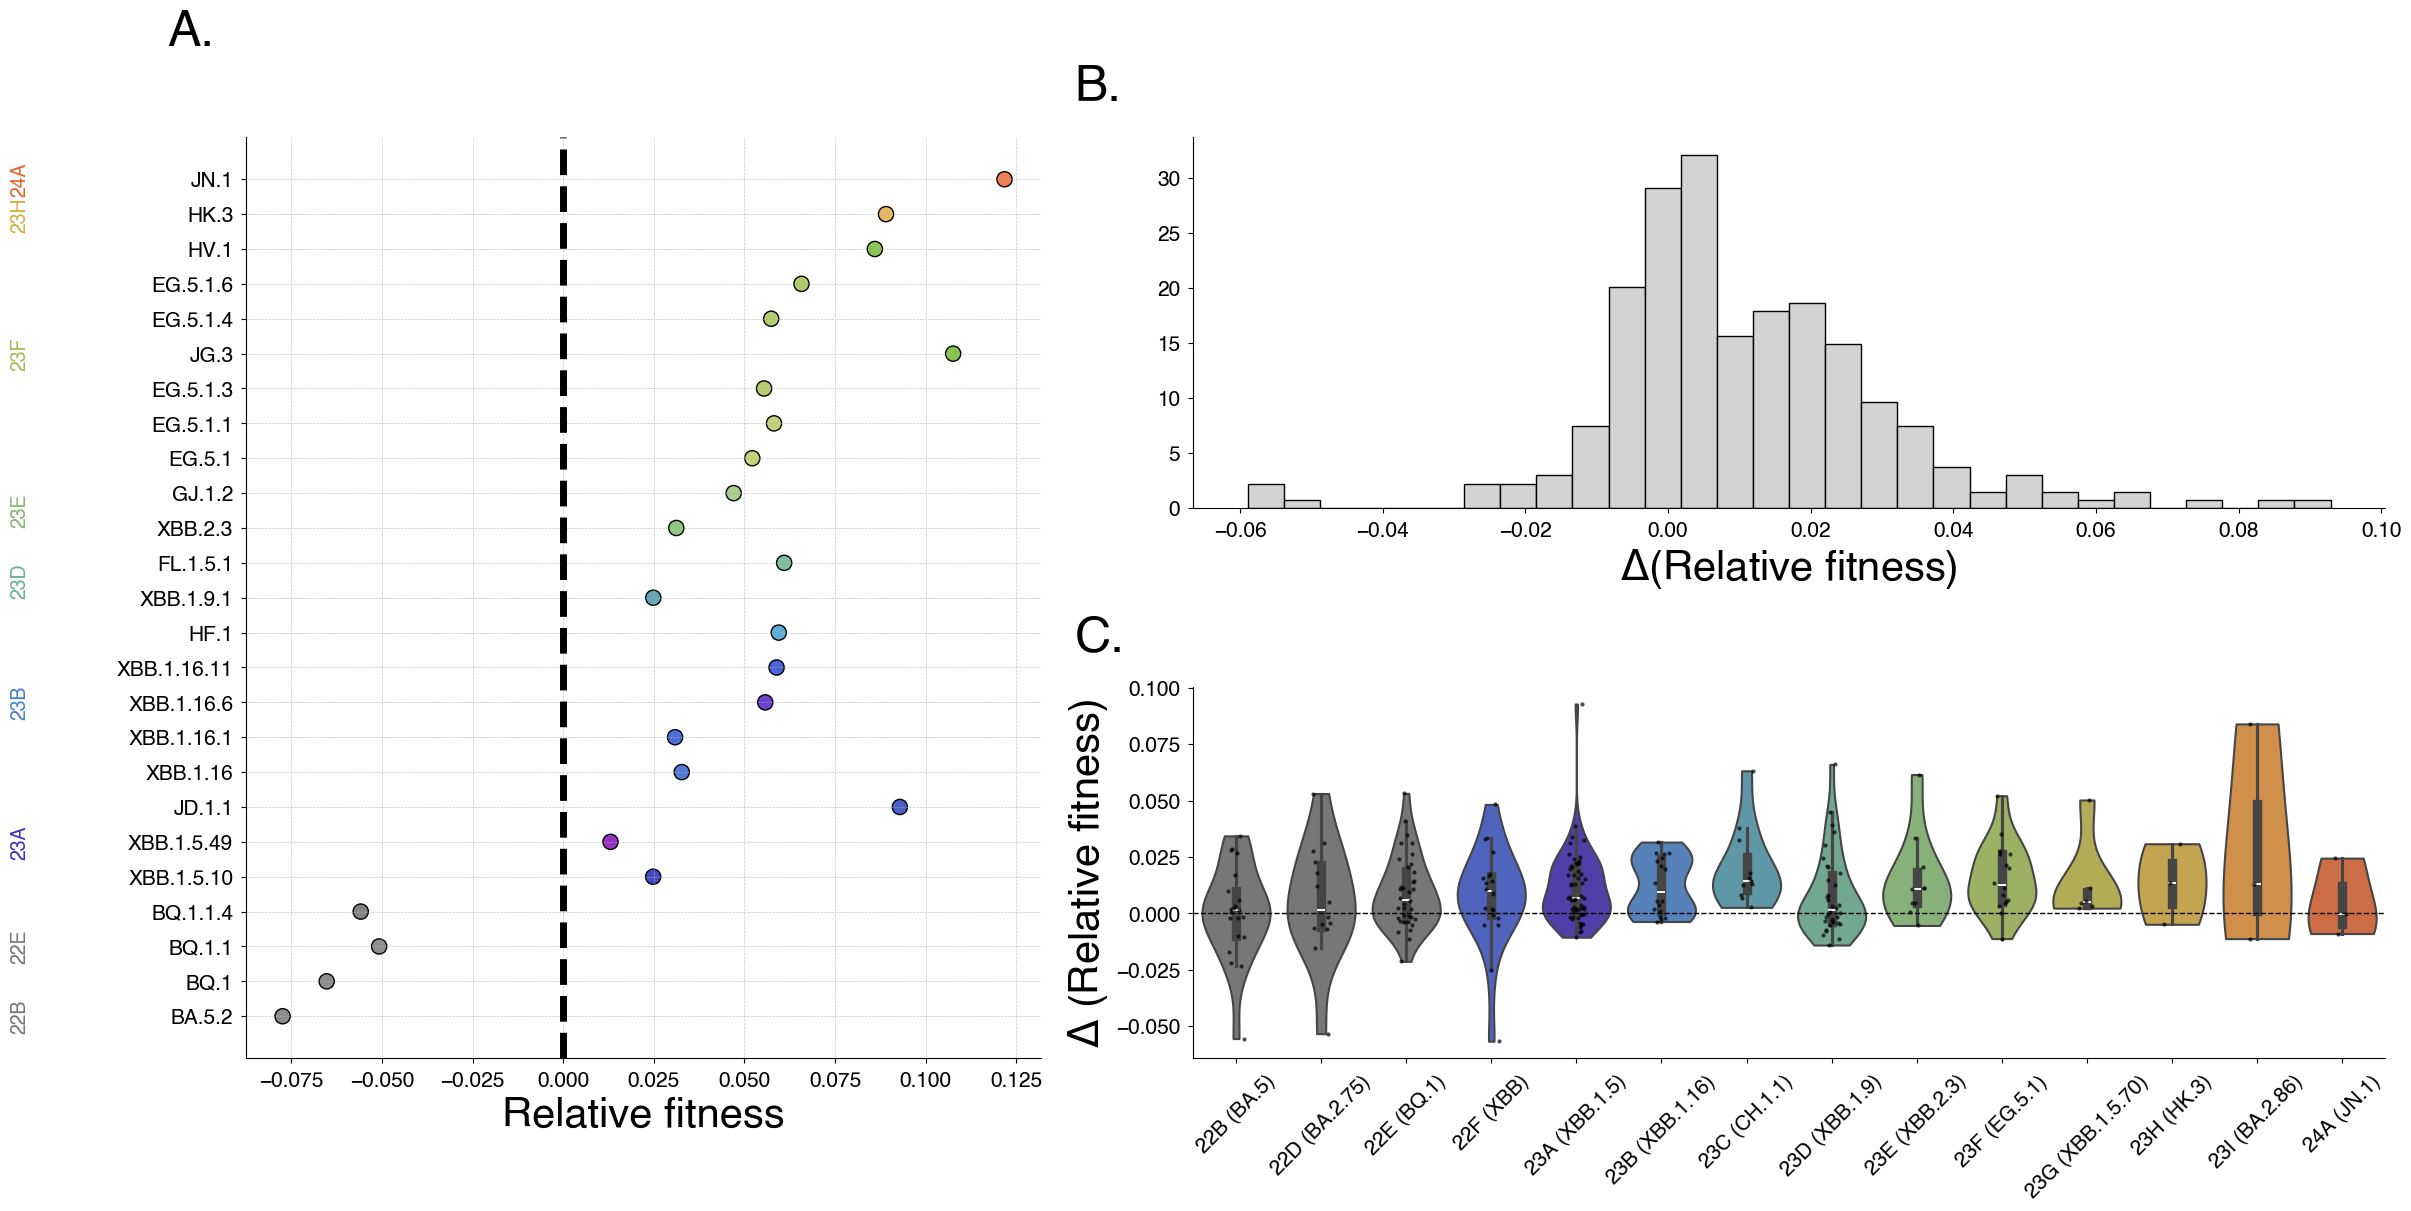

In [51]:
# Next figure estimating innovations!!
fig = plt.figure(figsize=(24, 12),  constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1.5])

freq_thres = 0.02

# A. Relative fitness 
ax_relative_fitness = fig.add_subplot(spec[:, 0])
plot_relative_fitness_vertical(ax_relative_fitness, posterior, thres=freq_thres)

# B. Distribution of innovations
ax_innovation_distribution = fig.add_subplot(spec[0, 1])
plot_innovation_distribution(ax_innovation_distribution, posterior)

# C. Clade innovations 
ax_innovation_distribution_clade = fig.add_subplot(spec[1, 1])
plot_clade_innovation_violin(ax_innovation_distribution_clade, posterior, clade_map, display_name_map, clade_color_map)

# Adding panel labels
axes = [ax_relative_fitness, ax_innovation_distribution, ax_innovation_distribution_clade]
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')


In [52]:
fig.savefig("../manuscript/figures/exploring-fitness-innovations.png")

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np

def calculate_partial_explained_variance(X, y):
    """
    Calculate partial explained variance (partial R^2) for each predictor in a linear regression model.
    
    Parameters:
        X (pd.DataFrame or np.ndarray): Predictor variables (features).
        y (pd.Series or np.ndarray): Target variable.
        
    Returns:
        pd.DataFrame: A DataFrame with predictors and their partial explained variance values.
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
    
    # Full model fit
    full_model = LinearRegression()
    full_model.fit(X, y)
    full_explained_variance = explained_variance_score(y, full_model.predict(X))
    
    partial_explained_variance_results = []
    
    # Loop through each predictor
    for predictor in X.columns:
        # Remove one predictor
        X_reduced = X.drop(columns=[predictor])
        
        # Fit the reduced model
        reduced_model = LinearRegression()
        reduced_model.fit(X_reduced, y)
        reduced_explained_variance = explained_variance_score(y, reduced_model.predict(X_reduced))
        
        # Calculate partial explained variance for the removed predictor
        partial_explained_variance = full_explained_variance - reduced_explained_variance
        partial_explained_variance_results.append({"predictor": predictor, "partial_r2": partial_explained_variance})
    
    return pd.DataFrame(partial_explained_variance_results).sort_values(by="partial_r2", ascending=False)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_43135/3045859267.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_predictor_weights.set_xticklabels(ax_predictor_weights.get_xticklabels(), rotation=90)


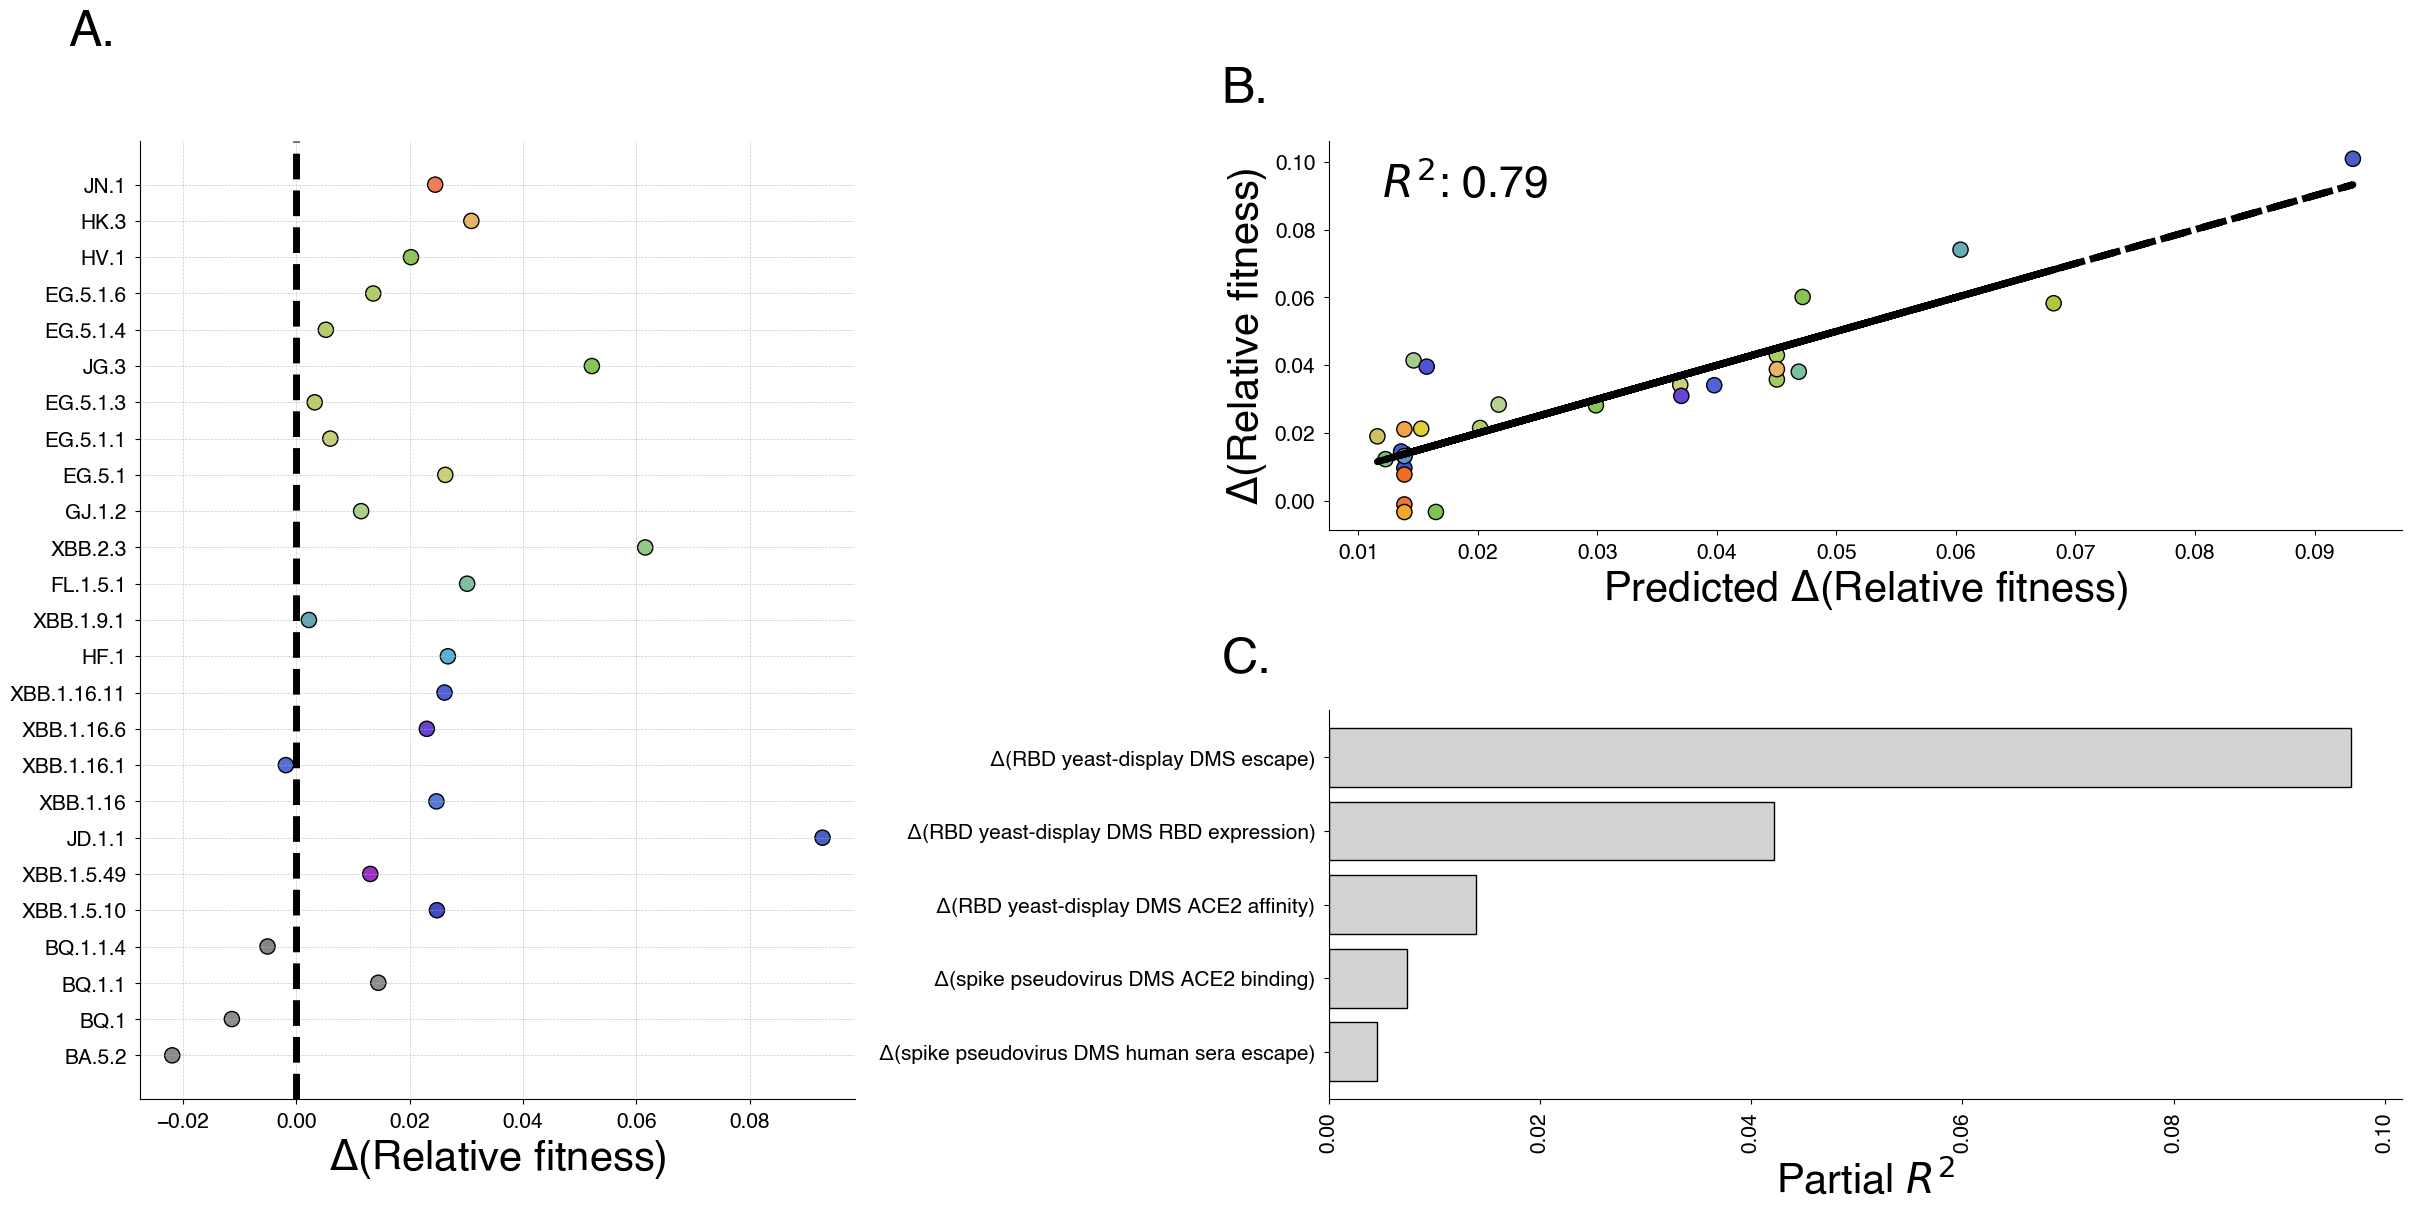

In [54]:
fig = plt.figure(figsize=(24, 12),  constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1,1.5])

freq_thres = 0.02

# A. Relative fitness delta
ax_relative_fitness_innovation = fig.add_subplot(spec[:, 0])
plot_relative_fitness_innovation_vertical(ax_relative_fitness_innovation, posterior, thres=freq_thres)
ax_relative_fitness_innovation.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
ax_relative_fitness_innovation.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

# D. Innovations in multiregression
ax_multiregression_innovation = fig.add_subplot(spec[0, 1])

# Prep predictors and outcome
df = predictors.reset_index().merge(ga_delta_df, how="left")[:-1]
df = df.dropna()
X = df[["delta_" + name for name in predictor_names]]
xs = X.values
log_ga_delta = np.log(df.median_ga_delta.values)

# Add comparison between observed and predicted
model = plot_multiple_regression(ax_multiregression_innovation, 
                                 predictors=xs, 
                                 outcome=log_ga_delta, 
                                 color=[color_map[v] for v in df["variant"].values],
                                 )
ax_multiregression_innovation.set_xlabel("Predicted " + r"$\Delta$" + "(Relative fitness)")
ax_multiregression_innovation.set_ylabel(r"$\Delta$" + "(Relative fitness)")

ax_predictor_weights = fig.add_subplot(spec[1,1])

partial_explained_variance_df = calculate_partial_explained_variance(X, log_ga_delta)
# Modify predictor names
def format_label(label):
    # Replace 'delta_' with 'Δ'
    label = label.replace("delta_", "Δ(")
    # Truncate after 'relative'
    if "relative" in label:
        label = label.split("relative")[0].strip()
    return label + ")"
    
# Apply formatting to predictor labels
partial_explained_variance_df["predictor"] = partial_explained_variance_df["predictor"].apply(format_label)


# Plot the bar chart
ax_predictor_weights.barh(partial_explained_variance_df["predictor"], partial_explained_variance_df["partial_r2"], color="lightgrey", ec='k')
ax_predictor_weights.set_xlabel(r"Partial $R^2$")
ax_predictor_weights.set_xticklabels(ax_predictor_weights.get_xticklabels(), rotation=90)
ax_predictor_weights.invert_yaxis()  # Invert y-axis to have the highest variance at the top

#betas = model.coef_
#ind_betas = np.arange(len(betas))
#ax_predictor_weights.scatter(betas, ind_betas, ec="k", color="lightblue", s=80)
#ax_predictor_weights.axvline(0.0, color="k", linestyle="--")
#ax_predictor_weights.set_yticks(ind_betas)
#ax_predictor_weights.set_yticklabels([rf"$\Delta$({name})" for name in predictor_names], size=16)
#ax_predictor_weights.set_xlabel(r"$\beta_{p}$")



# Adding panel labels
axes = [ax_relative_fitness_innovation, ax_multiregression_innovation, ax_predictor_weights]
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

In [57]:
partial_explained_variance_df

predictor  partial_r2
4             Δ(RBD yeast-display DMS escape)    0.096746
3     Δ(RBD yeast-display DMS RBD expression)    0.042146
2      Δ(RBD yeast-display DMS ACE2 affinity)    0.013929
1       Δ(spike pseudovirus DMS ACE2 binding)    0.007429
0  Δ(spike pseudovirus DMS human sera escape)    0.004609

In [55]:
fig.savefig("../manuscript/figures/explaining-fitness-innovations.png")

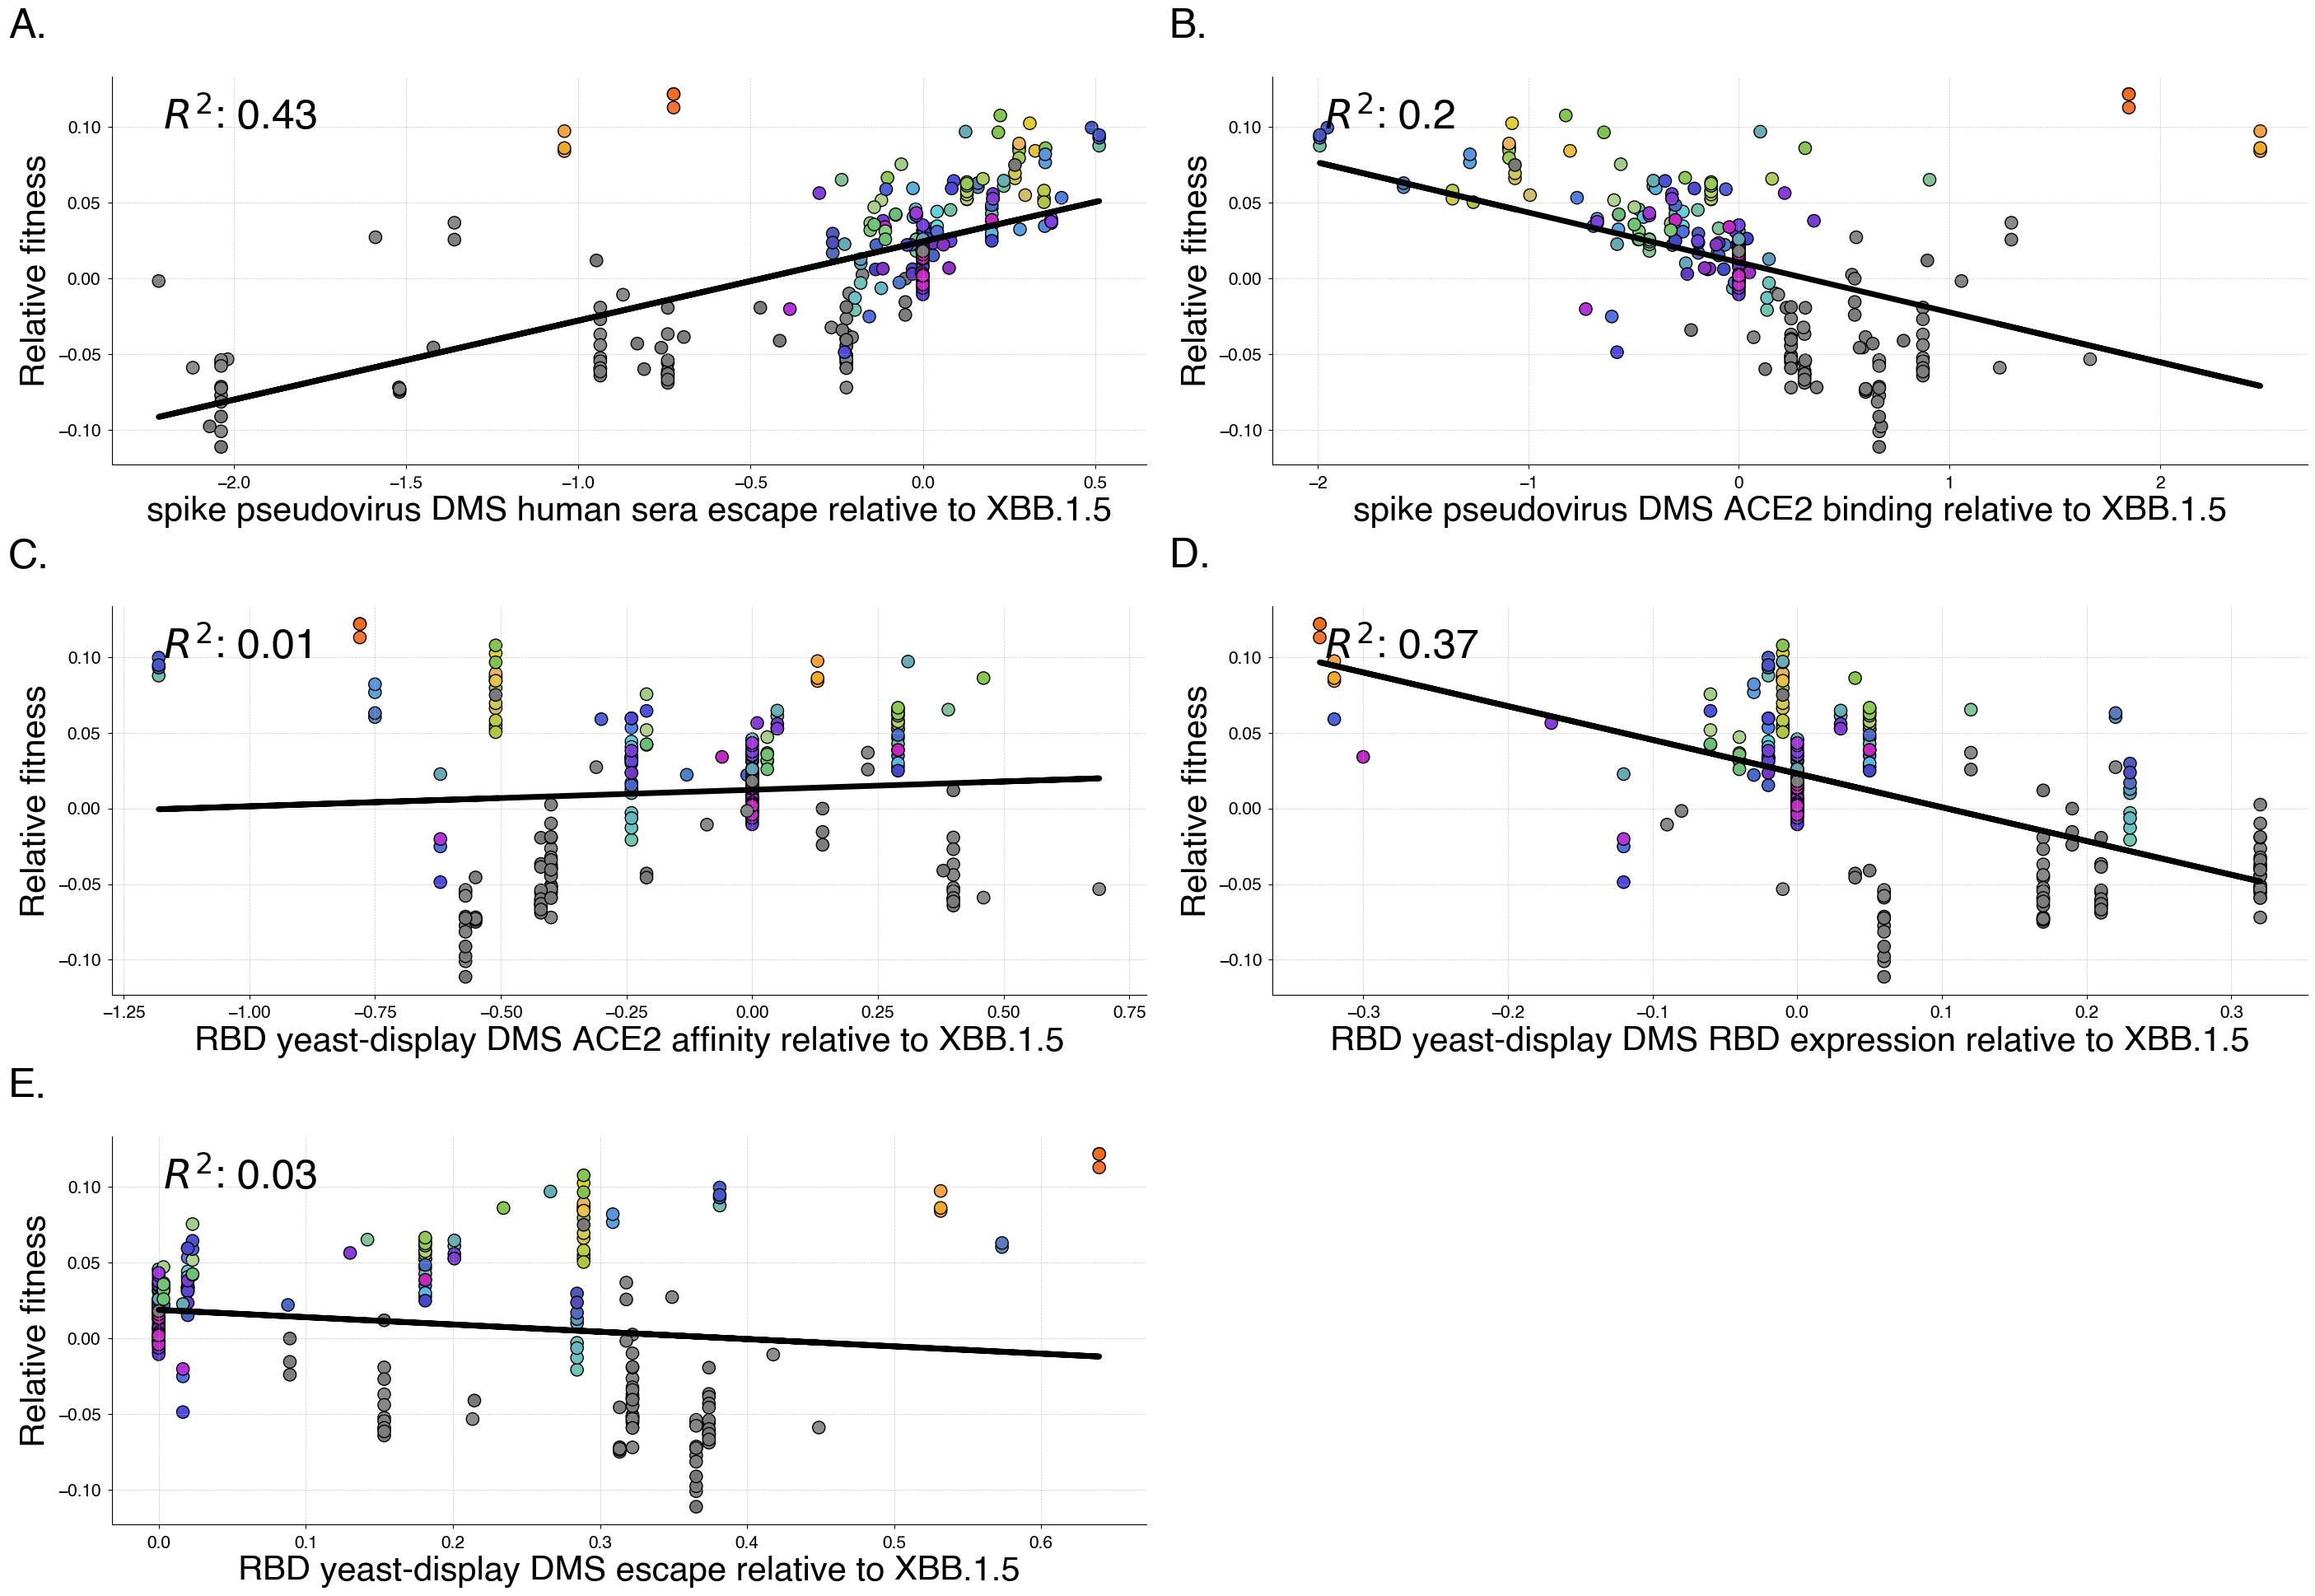

In [49]:
# This is naive regressions
fig = plt.figure(figsize=(28, 24),  constrained_layout=True)
gs = fig.add_gridspec(nrows=4, ncols=2)

# Defining growth advantages
df = predictors.reset_index().merge(ga_df, how="left")[:-1]
log_ga = np.log(df.median_ga.values)

# Loop over predictor increments and plot
axes = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p])
    plot_single_regression(ax, 
                          predictor = df[name].values, 
                          outcome = log_ga,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = name,
                          ylabel = "Relative fitness")
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    axes.append(ax)
    
# Adding panel labels    
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')


In [50]:
fig.savefig("../manuscript/supplementary_figures/relative-fitness-single-regressions.png")

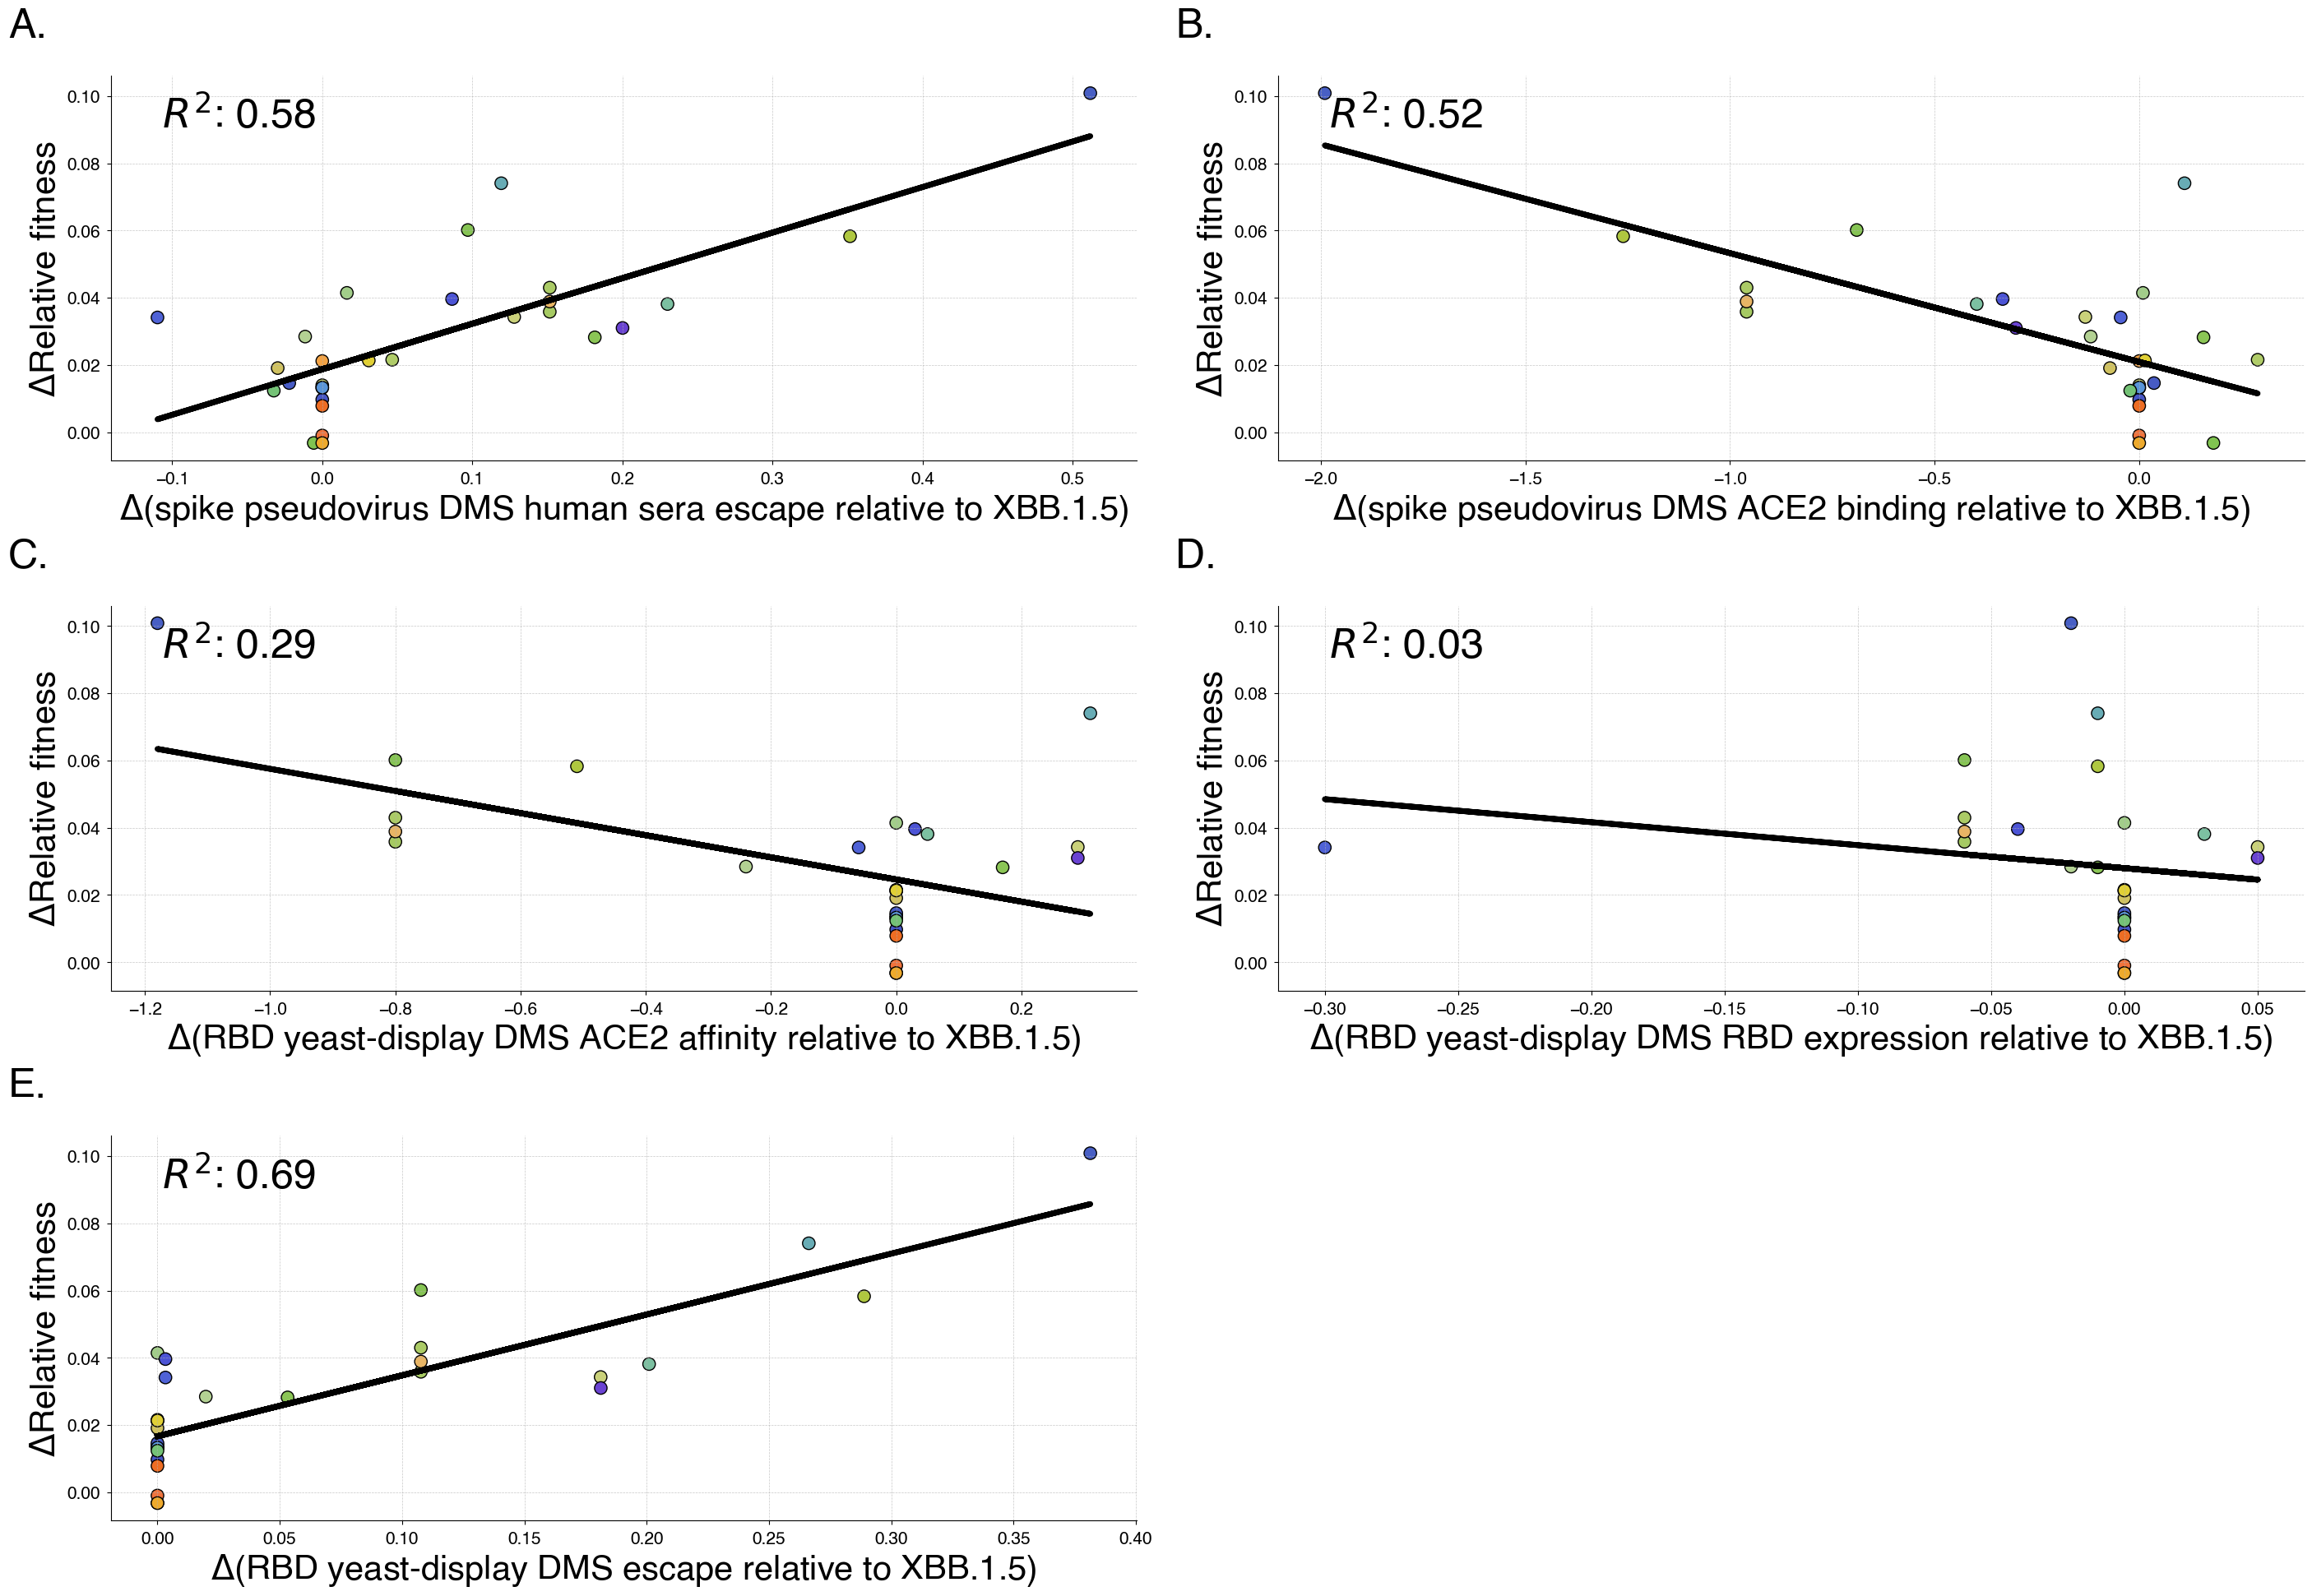

In [51]:
# This goes with supplement showing correlations for all individual features
fig = plt.figure(figsize=(28, 24),  constrained_layout=True)
gs = fig.add_gridspec(nrows=4, ncols=2)

# Defining growth advantage innovation
df = predictors.reset_index().merge(ga_delta_df, how="left")
df = df.dropna()
log_ga_delta = np.log(df.median_ga_delta.values)

# Loop over predictor increments and plot
axes = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p])
    plot_single_regression(ax, 
                          predictor = df["delta_"+name].values, 
                          outcome = log_ga_delta,
                          color=[color_map[v] for v in df["variant"].values],
                          xlabel = rf"$\Delta$({name})",
                          ylabel = r"$\Delta$" + "Relative fitness")
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    axes.append(ax)
    
# Adding panel labels    
ax_labels = [letter  for letter in string.ascii_uppercase]
for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')


In [52]:
fig.savefig("../manuscript/supplementary_figures/relative-fitness-innovations-single-regressions.png")

In [53]:
# Next figure shows the regression model

# Loading regression model
with open(f"../results/{ANALYSIS}/posteriors/informed/samples_USA.pkl", 'rb') as f:
    samples = pickle.load(f)

posterior_regression = ef.PosteriorHandler(samples=samples, data=data)

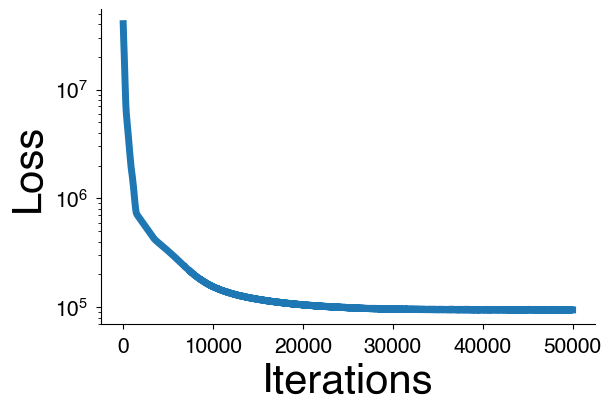

In [54]:
if "losses" in posterior_regression.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior_regression.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [55]:
posterior_regression.samples

{'delta_loc_missing': Array([[ 0.03318114, -0.00504857, -0.01869172,  0.03751728]], dtype=float32),
 'delta_scale': Array([0.01770786], dtype=float32),
 'raw_alpha': Array([[ -4.4684157 ,  -3.6497157 , -24.142122  , -26.212198  ,
          -3.5936403 ,  -2.4797726 ,  -1.7393117 ,  -2.8540895 ,
          -6.8423724 ,  -3.1134477 ,  -3.0966916 ,  -3.4023135 ,
          -5.0487185 ,  -3.7580304 ,  -5.349245  ,  -2.4000795 ,
          -5.686603  ,  -7.510818  ,  -3.739509  ,  -3.1505516 ,
          -4.7784805 ,  -7.367634  ,  -7.553261  ,  -7.687037  ,
          -3.582812  ,  -3.7373626 ,  -6.6318264 ,  -4.518504  ,
          -4.01042   ,  -0.57365125,   0.4150219 ,  -3.5528553 ,
          -3.4745443 ,  -4.3310943 ,  -5.080516  ,  -2.3670533 ,
          -6.3063903 ,  -5.120195  ,  -5.2195244 ,  -2.4622755 ,
          -2.416335  ,  -4.5524135 ,  -1.9225714 ,  -5.7639523 ,
          -8.339949  ,  -2.4109747 ,  -3.133213  ,  -3.4863503 ,
          -2.6191902 ,  -3.0464675 ,  -2.4821098 ,  -3.

In [56]:
def _prep_predictors(predictors, var_names, parent_map, predictor_names):
    # Index by variant name
    #predictors = predictors.rename(columns={"clade": "variant"}).set_index("variant")
    predictors = predictors.rename(columns={"lineage": "variant"}).set_index("variant")
    predictors = (predictors
                     .replace("?")
                     .astype({name: "float" for name in predictor_names}))
    
    # Find scores of interest and parents
    var_names = [v for v in var_names if v in predictors.index]
    predictors = predictors.loc[var_names] # Need all variants to be present...
    predictors["parent"] = predictors.index.map(data.parent_map)
    predictors = predictors.drop_duplicates(inplace=False)

    # Get delta between parents and children
    def get_parent_delta(x, col):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in predictors.index:
            return predictors.loc[variant][col] - predictors.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    for name in predictor_names:
        predictors[f"delta_{name}"] = predictors.apply(lambda x: get_parent_delta(x, name), axis=1) 
    return predictors

def preprocess_predictors(predictors, var_names, parent_map, predictor_names, intercept=True):
    """
    Preprocess predictors for all lineages.

    Parameters
    ----------
    predictors : pd.DataFrame
        DataFrame containing predictors and their values for each lineage.
    predictor_names : list of str
        Names of predictors (e.g., molecular phenotypes like immune escape, ACE2 binding).
    intercept : bool, optional
        Whether to include an intercept in the predictors. Defaults to True.

    Returns
    -------
    pd.DataFrame
        Preprocessed predictors with deltas calculated and intercept added if specified.
    """
    # Prepare predictors and compute deltas
    predictors = _prep_predictors(predictors, var_names, parent_map, predictor_names)

    # Add intercept if needed
    if intercept:
        predictors["intercept"] = 1.0

    return predictors

def predict_fitness_for_lineages(lineages, parent_lineages, posterior, predictor_names):
    """
    Predict relative fitness for a list of lineages using preprocessed predictors.

    Parameters
    ----------
    lineages : list of str
        List of lineage names to predict fitness for.
    parent_lineages : list of str
        List of parent lineage names corresponding to each lineage in `lineages`.
    posterior : dict
        Posterior samples and data, with keys `posterior.data` (training data) and `posterior.samples` (model parameters).
    predictor_names : list of str
        Names of predictors (e.g., molecular phenotypes like immune escape, ACE2 binding).

    Returns
    -------
    pd.DataFrame
        A DataFrame with predicted fitness, predicted innovation, and parent fitness for each lineage.
    """
    import pandas as pd
    
    
    # Check that lineages and parent_lineages are the same length
    if len(lineages) != len(parent_lineages):
        raise ValueError("The `lineages` and `parent_lineages` lists must have the same length.")
    
    var_names = posterior.data.var_names
    var_names = var_names + lineages
    parent_map = posterior.data.parent_map
    for lineage, parent in zip(lineages, parent_lineages):
        parent_map[lineage] = parent

    predictors = pd.read_csv("../data/xbb15/phenotypes/lineage_phenotypes.csv").rename(columns={"lineage":"variant"})
    predictors = preprocess_predictors(predictors, var_names, parent_map, predictor_names, intercept=True)
    # Initialize results list
    results = []

    # Extract parent fitness and loop through lineages
    for lineage, parent_lineage in zip(lineages, parent_lineages):
        try:
            # Get parent fitness samples
            if parent_lineage not in posterior.data.var_names:
                raise ValueError(f"Parent lineage {parent_lineage} not found in posterior data.")
            parent_index = posterior.data.var_names.index(parent_lineage)

            # Extend relative fitness to allow for base variant
            relative_fitness = np.log(np.array(posterior.samples["ga"]))
            relative_fitness = np.pad(relative_fitness, ((0, 0), (0, 1)))  # Padding for base variant
            parent_fitness_samples = relative_fitness[:, parent_index]

            # Get predictors for the lineage
            if lineage not in predictors.index:
                raise ValueError(f"Lineage {lineage} not found in predictors.")
            lineage_predictors = predictors.loc[lineage][predictor_names + ["intercept"]].values.reshape(1, -1)
            
            # Predict innovation
            theta = posterior.samples["theta"]
            delta_scale = posterior.samples["delta_scale"]            
            delta_loc = np.dot(lineage_predictors, theta.T)  # Shape: (1, n_samples)
            sampled_delta = delta_loc + np.random.normal(0, delta_scale, size=delta_loc.shape)
            # TODO: ADD OPTIONAL UNCERTAINTY FOR MAP

            # Combine the innovation with parent fitness
            predicted_fitness = parent_fitness_samples + delta_loc.flatten()
            sampled_fitness = parent_fitness_samples[:, None] + sampled_delta.flatten()

            # Append results
            results.append({
                "variant": lineage,
                "parent_lineage": parent_lineage,
                "predicted_fitness_mean": predicted_fitness.mean(),
                "predicted_innovation_mean": delta_loc.mean(),
                "parent_fitness_mean": parent_fitness_samples.mean(),
                "predicted_fitness_samples": sampled_fitness,
                "predicted_innovation_samples": sampled_delta
            })
        except ValueError as e:
            print(f"Skipping {lineage}: {e}")
    
    # Convert results to DataFrame for easy analysis
    return pd.DataFrame(results)

In [58]:
lineages = ["XBB.1.16", "EG.5.1", "BA.5"]
parent_lineages = ["XBB.1.5", "EG.5", "BA.2"]


results_df = predict_fitness_for_lineages(
    lineages=lineages,
    parent_lineages=parent_lineages,
    posterior=posterior_regression,
    predictor_names=predictor_names
)

Skipping EG.5.1: Parent lineage EG.5 not found in posterior data.
Skipping BA.5: Parent lineage BA.2 not found in posterior data.


In [59]:
results_df

variant parent_lineage  predicted_fitness_mean  predicted_innovation_mean  \
0  XBB.1.16        XBB.1.5                0.006406                   0.006406   

   parent_fitness_mean    predicted_fitness_samples  \
0                  0.0  [[-0.00015398298719767386]]   

  predicted_innovation_samples  
0  [[-0.00015398298719767386]]

In [60]:
fresh_predictors = pd.read_csv("../data/xbb15/phenotypes/lineage_phenotypes.csv").rename(columns={"lineage":"variant"})
jn_1_descendents = fresh_predictors[fresh_predictors.variant.str.startswith("JN.1")].variant.values

In [61]:
"JN.1.1" in posterior.data.var_names

for desc in jn_1_descendents:
    if desc not in posterior.data.var_names:
        print(desc)

JN.1.1.1
JN.1.1.2
JN.1.1.3
JN.1.1.4
JN.1.1.5
JN.1.1.6
JN.1.1.7
JN.1.2
JN.1.2.1
JN.1.3
JN.1.4.1
JN.1.4.2
JN.1.4.3
JN.1.4.4
JN.1.4.5
JN.1.4.6
JN.1.4.7
JN.1.5
JN.1.6
JN.1.6.1
JN.1.7
JN.1.7.1
JN.1.7.2
JN.1.7.3
JN.1.7.4
JN.1.8
JN.1.8.1
JN.1.8.2
JN.1.8.3
JN.1.8.4
JN.1.9
JN.1.9.1
JN.1.9.2
JN.1.10
JN.1.11
JN.1.11.1
JN.1.12
JN.1.13
JN.1.13.1
JN.1.14
JN.1.15
JN.1.16
JN.1.16.1
JN.1.16.2
JN.1.17
JN.1.18
JN.1.18.1
JN.1.18.2
JN.1.19
JN.1.20
JN.1.21
JN.1.22
JN.1.23
JN.1.24
JN.1.24.1
JN.1.25
JN.1.25.1
JN.1.26
JN.1.27
JN.1.28
JN.1.28.1
JN.1.29
JN.1.30
JN.1.30.1
JN.1.31
JN.1.32
JN.1.32.1
JN.1.33
JN.1.34
JN.1.35
JN.1.36
JN.1.36.1
JN.1.37
JN.1.38
JN.1.39
JN.1.40
JN.1.41
JN.1.42
JN.1.42.1
JN.1.43
JN.1.43.1
JN.1.44
JN.1.45
JN.1.46
JN.1.47
JN.1.47.1
JN.1.47.2
JN.1.48
JN.1.48.1
JN.10
JN.11
JN.12
JN.13
JN.13.1
JN.14


In [62]:
lineages = ["XBB.1.16", "JN.1.1.1", "JN.1.48",  "JN.1.4.1", "BA.5"]
parent_lineages = ["XBB.1.5", "JN.1", "JN.1", "JN.1.4" ,"BA.2"]

results_df = predict_fitness_for_lineages(
    lineages=lineages,
    parent_lineages=parent_lineages,
    posterior=posterior_regression,
    predictor_names=predictor_names
)

results_df

Skipping BA.5: Parent lineage BA.2 not found in posterior data.


variant parent_lineage  predicted_fitness_mean  predicted_innovation_mean  \
0  XBB.1.16        XBB.1.5                0.006406                   0.006406   
1  JN.1.1.1           JN.1                0.138532                   0.017426   
2   JN.1.48           JN.1                0.143684                   0.022577   
3  JN.1.4.1         JN.1.4                0.144076                   0.023158   

   parent_fitness_mean predicted_fitness_samples predicted_innovation_samples  
0             0.000000  [[0.006028798280731837]]     [[0.006028798280731837]]  
1             0.121106    [[0.1217780712987309]]    [[0.0006717074657803107]]  
2             0.121106   [[0.09412385623656694]]     [[-0.02698250759638366]]  
3             0.120918   [[0.13080102215234268]]     [[0.009883090953268878]]

In [67]:
def plot_relative_fitness_prediction_results(ax, results_df, outcome_column="predicted_fitness_mean", color_column="clade", color_map=None):
    """
    Visualize relative fitness from `results_df` in a vertical scatter plot with clade-based ordering.

    Parameters
    ----------
    ax : matplotlib.axes._axes.Axes
        The axis on which to plot.
    results_df : pd.DataFrame
        DataFrame containing prediction results, including innovations and lineage information.
    outcome_column : str
        Column containing outcome_column (default is `predicted_fitness_mean`).
    color_column : str
        Column to use for color-coding (default is `clade`).
    color_map : dict
        Dictionary mapping `color_column` values to specific colors.

    Returns
    -------
    None
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Get clade-based ordering using variant names
    # Extract variant names and determine clade-based ordering
    var_names = list(results_df["variant"].unique())
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)
    reordered_results = results_df.loc[reordered_idx]

    # Prepare color mapping
    colors = results_df[color_column].map(color_map).fillna("#777777").values

    # Scatter plot
    ax.scatter(
        results_df[outcome_column],
        np.arange(len(results_df)),
        c=colors,
        s=120,
        edgecolor="k",
        label=None,
    )

    # Set labels and aesthetics
    ax.set_yticks(np.arange(len(results_df)))
    ax.set_yticklabels(results_df["variant"])
    ax.set_xlabel("Relative fitness")
    ax.axvline(x=0.0, linestyle="--", color="k", linewidth=1.8)
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

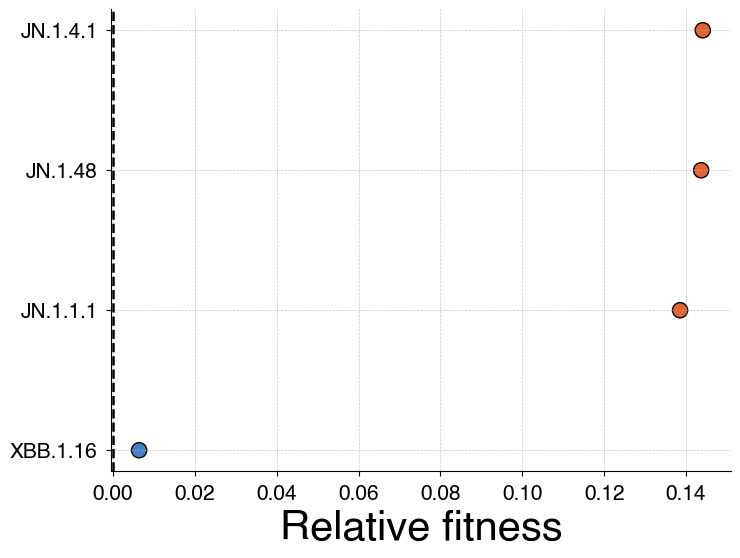

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

clade_map = {
    lineage: lineage_to_clade(lineage, aliasor, "other", clade_definitions)
    for lineage in data.var_names
}


# Extend clade_map
for lineage in results_df.variant.values:
    clade_map[lineage] = lineage_to_clade(lineage, aliasor, "other", clade_definitions)
    color_map_by_clade[lineage]  = clade_color_map[clade_map[lineage]]
    
plot_relative_fitness_prediction_results(
    ax=ax,
    results_df=results_df,
    outcome_column="predicted_fitness_mean",
    color_column="variant",
    color_map=color_map_by_clade
)

In [ ]:
# TODO: Get a test set :-)